**Les Membres du groupe :**
- KOUCH HAJAR
- LAARAJ IMANE
- ZMIRLI MUSTAPHA

# Analyse des données d'économie, emploi et éducation avec l'API OCDE
**Introduction :**
Les inégalités en matière de développement humain et d'emploi constituent des enjeux majeurs dans le monde contemporain. Ces disparités sont influencées par une combinaison complexe de facteurs économiques, éducatifs, sociaux et démographiques. **L'objectif de cette étude est de comprendre comment ces indicateurs interagissent et contribuent aux différences de développement entre les pays et les régions.**

Dans ce notebook, nous analysons des données issues des pays membres de l'OCDE ainsi que World Bank, collectées pour l'année 2021 à partir de l'API de l'OCDE et l'api World Bank. Cette analyse intégrée porte sur des domaines clés, notamment les niveaux d'éducation, les politiques fiscales, les investissements publics et les variables macroéconomiques. Elle vise à répondre aux questions suivantes :

*  Comment les niveaux d'éducation et les domaines d'études influencent-ils les taux d'emploi et de chômage au sein de différents groupes démographiques ?

* Quels sont les effets des politiques fiscales et des investissements publics sur les indicateurs socio-économiques ?

* En quoi les variables macroéconomiques et sociales, comme le PIB ou les dépenses publiques en santé et éducation, expliquent-elles les disparités de développement humain entre pays et régions ?

**Importation des bibliotheques :**

In [ ]:
import requests
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from statsmodels.stats.diagnostic import het_white
from scipy.stats import shapiro
from sklearn.linear_model import LinearRegression
import scipy.cluster.hierarchy as shc
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from statsmodels.stats.anova import anova_lm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import statsmodels.formula.api as smf
import scipy.stats as stats
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from adjustText import adjust_text

# 1. Chargement des données de l'api OCDE :


**Pour accéder aux données depuis l'API OCDE, nous utiliserons la bibliothèque pandas et des requêtes HTTP via requests.**

In [ ]:
# URLs des ensembles de données
ocde_DATA_url='https://sdmx.oecd.org/public/rest/data/OECD.SDD.TPS,DSD_PPP@DF_PPP,1.0/DEU+AUS+AUT+BEL+CAN+CHL+COL+KOR+CRI+DNK+ESP+EST+USA+FIN+FRA+GRC+HUN+IRL+ISL+ITA+JPN+LVA+LTU+LUX+MEX+NOR+NZL+NLD+POL+PRT+SVK+GBR+SVN+SWE+CHE+CZE+TUR.A.PPP.A01+A0101+A010101+A01010101+A01010102+A01010103+A01010104+A01010105+A01010106+A01010199+A010102+A0102+A010201+A010202+A0103+A0104+A0105+A0106+A010601+A0107+A010701+A0108+A0109+A0110+A0111+A0112.XDC_USD.OECD?startPeriod=2021&endPeriod=2021&dimensionAtObservation=AllDimensions&format=csvfilewithlabels'
taux_chomage_url='https://sdmx.oecd.org/public/rest/data/OECD.EDU.IMEP,DSD_EAG_LSO_EA@DF_LSO_NEAC_UNEMP_FIELD,1.0/SWE+IRL+LUX+AUS+AUT+BEL+CHL+CRI+CZE+DNK+EST+FIN+FRA+DEU+GRC+HUN+ISL+ITA+LVA+LTU+MEX+NLD+NOR+POL+PRT+SVK+SVN+ESP+CHE+TUR+GBR+USA.F+M.Y55T64+Y45T54+Y35T44+Y25T34.ISCED11A_7_8+ISCED11A_6+ISCED11A_5+ISCED11A_5T8.F00_08_10+F05T07+F022T03+F02_03+F01+F02+F03+F04+F05+F06+F07+F08+F09+F10.........OBS...A3?startPeriod=2021&endPeriod=2021&dimensionAtObservation=AllDimensions&format=csvfilewithlabels'
taux_emploi_url='https://sdmx.oecd.org/public/rest/data/OECD.EDU.IMEP,DSD_EAG_LSO_EA@DF_LSO_NEAC_EMP_FIELD,1.0/SWE+IRL+LUX+AUS+AUT+BEL+CHL+CRI+CZE+DNK+EST+FIN+FRA+DEU+GRC+HUN+ISL+ITA+LVA+LTU+MEX+NLD+NOR+POL+PRT+SVK+SVN+ESP+CHE+TUR+GBR+USA.F+M.Y25T64.ISCED11A_7_8+ISCED11A_5+ISCED11A_6.F01+F02+F03+F04+F05+F06+F07+F08+F09+F10.........OBS...A3?startPeriod=2021&endPeriod=2021&lastNObservations=1&dimensionAtObservation=AllDimensions'
# Liste des URLs avec leurs noms de fichier correspondants
urls = [
    {"url": ocde_DATA_url, "filename": "ocde_DATA.csv"},
    {"url": taux_chomage_url, "filename": "Taux_Chomage.csv"},
    {"url": taux_emploi_url, "filename": "taux_emploi.csv"}
]

# En-têtes de la requête
headers = {
    'Accept': 'application/vnd.sdmx.data+csv; charset=utf-8'
}

# Fonction pour télécharger et sauvegarder les données
def download_data(url, filename):
    response = requests.get(url, headers=headers)
    if response.status_code == 200:
        with open(filename, 'w', encoding='utf-8') as file:
            file.write(response.text)
        print(f"Le fichier '{filename}' a été téléchargé avec succès.")
    else:
        print(f"Erreur {response.status_code} lors du téléchargement de {filename}")

# Boucle pour télécharger chaque jeu de données
for item in urls:
    download_data(item["url"], item["filename"])


Le fichier 'ocde_DATA.csv' a été téléchargé avec succès.
Le fichier 'Taux_Chomage.csv' a été téléchargé avec succès.
Le fichier 'taux_emploi.csv' a été téléchargé avec succès.


In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


# 2. Taux d'emploi dataset :


Ce dataset fournit des informations sur le taux d'emploi selon :
          

*   le niveau d'étude  .
*   le domaine d'étude.
*   les groupes d'age et le genre selon différents pays

In [ ]:
# Charger le fichier CSV
tauxEmploi = pd.read_csv("/content/drive/MyDrive/tauxEmp2021.csv")
tauxEmploi.head()

,STRUCTURE,STRUCTURE_ID,STRUCTURE_NAME,ACTION,REF_AREA,Zone de référence,SEX,Sexe,AGE,Âge,...,OBS_VALUE,Valeur d'observation,OBS_STATUS,Statut d'observation,CONF_STATUS,Statut de confidentialité,UNIT_MULT,Multiplicateur d'unités,DECIMALS,Décimales
0,DATAFLOW,OECD.EDU.IMEP:DSD_EAG_LSO_EA@DF_LSO_NEAC_EMP_F...,Taux d'emploi des adultes diplômés de l'enseig...,I,GBR,Royaume-Uni,M,Sexe masculin,Y25T34,De 25 à 34 ans,...,NaN,NaN,O,NaN,NaN,NaN,0,NaN,1,NaN
1,DATAFLOW,OECD.EDU.IMEP:DSD_EAG_LSO_EA@DF_LSO_NEAC_EMP_F...,Taux d'emploi des adultes diplômés de l'enseig...,I,AUT,Autriche,F,Sexe féminin,Y55T64,De 55 à 64 ans,...,NaN,NaN,O,NaN,NaN,NaN,0,NaN,1,NaN
2,DATAFLOW,OECD.EDU.IMEP:DSD_EAG_LSO_EA@DF_LSO_NEAC_EMP_F...,Taux d'emploi des adultes diplômés de l'enseig...,I,NLD,Pays-Bas,F,Sexe féminin,Y35T44,De 35 à 44 ans,...,NaN,NaN,O,NaN,NaN,NaN,0,NaN,1,NaN
3,DATAFLOW,OECD.EDU.IMEP:DSD_EAG_LSO_EA@DF_LSO_NEAC_EMP_F...,Taux d'emploi des adultes diplômés de l'enseig...,I,NLD,Pays-Bas,F,Sexe féminin,Y45T54,De 45 à 54 ans,...,81.568626,NaN,A,NaN,NaN,NaN,0,NaN,1,NaN
4,DATAFLOW,OECD.EDU.IMEP:DSD_EAG_LSO_EA@DF_LSO_NEAC_EMP_F...,Taux d'emploi des adultes diplômés de l'enseig...,I,EST,Estonie,M,Sexe masculin,Y55T64,De 55 à 64 ans,...,NaN,NaN,O,NaN,NaN,NaN,0,NaN,1,NaN


**Suppression des colonnes inutiles**

In [ ]:
# Supprimer les colonnes inutiles
colonnes_a_supprimer = [
    'STRUCTURE', 'STRUCTURE_ID', 'STRUCTURE_NAME', 'ACTION', 'REF_AREA',
     'Sexe', 'AGE','ATTAINMENT_LEV',
     'EDUCATION_FIELD', 'MEASURE',
    'Mesure', 'INCOME', 'Revenu', 'BIRTH_PLACE', 'Lieu de naissance',
    'MIGRATION_AGE', 'Âge au moment de la migration', 'EDU_STATUS',
    'Situation de scolarisation', 'LABOUR_FORCE_STATUS',
    'Situation d\'activité', 'DURATION_UNEMP', 'Durée du chômage',
    'UNIT_MEASURE', 'Unité de mesure', 'STATISTICAL_OPERATION',
    'Opération statistique', 'WORK_TIME_ARNGMNT',
    'Aménagement du temps de travail', 'QUESTIONNAIRE',
    'Nom du questionnaire', 'FREQ', 'Fréquence d\'observation',
    'TIME_PERIOD', 'Unnamed: 39', 'Valeur d\'observation',
    'OBS_STATUS', 'Statut d\'observation', 'CONF_STATUS',
    'Statut de confidentialité', 'UNIT_MULT', 'Multiplicateur d\'unités',
    'DECIMALS', 'Décimales'
]

# Vérifier si les colonnes existent avant de les supprimer pour éviter les erreurs
colonnes_existantes = [col for col in colonnes_a_supprimer if col in tauxEmploi.columns]
tauxEmploi = tauxEmploi.drop(columns=colonnes_existantes)



# Renommer les colonnes restantes si elles existent
colonnes_a_renommer = {
    'Zone de référence': 'Pays',
    'OBS_VALUE': 'taux emploi',
    'Âge':'Age',
    'SEX':'Genre',
    'Niveau de scolarité': 'Niveau de scolarite',
    'Domaine d’études': 'Domaine etudes'
}

# Vérifier si les colonnes à renommer existent
colonnes_existantes_renommage = {k: v for k, v in colonnes_a_renommer.items() if k in tauxEmploi.columns}
tauxEmploi = tauxEmploi.rename(columns=colonnes_existantes_renommage)

# Afficher un aperçu des données
tauxEmploi.head()


,Pays,Genre,Age,Niveau de scolarite,Domaine etudes,taux emploi
0,Royaume-Uni,M,De 25 à 34 ans,Enseignement tertiaire de cycle court,Santé et protection sociale,NaN
1,Autriche,F,De 55 à 64 ans,Niveau licence ou équivalent,Services (grand domaine),NaN
2,Pays-Bas,F,De 35 à 44 ans,Enseignement tertiaire de cycle court,Technologies de l’information et de la communi...,NaN
3,Pays-Bas,F,De 45 à 54 ans,Niveau licence ou équivalent,"Sciences, technologie, ingénierie et mathémati...",81.568626
4,Estonie,M,De 55 à 64 ans,Enseignement tertiaire de cycle court,"Sciences sociales, journalisme et information",NaN


**Suppression des doublons et remplacer des valeurs manquantes par les moyennes**

In [ ]:
# Vérifier les colonnes numériques
numerical_columns = tauxEmploi .select_dtypes(include=['number']).columns

# Remplacer les valeurs nulles uniquement dans les colonnes numériques par la moyenne
tauxEmploi[numerical_columns] = tauxEmploi [numerical_columns].fillna(tauxEmploi [numerical_columns].mean())

# Supprimer les doublons
tauxEmploi  = tauxEmploi .drop_duplicates()

tauxEmploi.head()


,Pays,Genre,Age,Niveau de scolarite,Domaine etudes,taux emploi
0,Royaume-Uni,M,De 25 à 34 ans,Enseignement tertiaire de cycle court,Santé et protection sociale,85.427044
1,Autriche,F,De 55 à 64 ans,Niveau licence ou équivalent,Services (grand domaine),85.427044
2,Pays-Bas,F,De 35 à 44 ans,Enseignement tertiaire de cycle court,Technologies de l’information et de la communi...,85.427044
3,Pays-Bas,F,De 45 à 54 ans,Niveau licence ou équivalent,"Sciences, technologie, ingénierie et mathémati...",81.568626
4,Estonie,M,De 55 à 64 ans,Enseignement tertiaire de cycle court,"Sciences sociales, journalisme et information",85.427044


In [ ]:
# Sauvegarder les données nettoyées dans un fichier CSV
tauxEmploi.to_csv('tauxEmploiClean.csv', index=False)

# 3. Taux de chomage dataset

**Le jeu de données "Taux de chômage des adultes diplômés de l'enseignement supérieur" fournit des informations sur le taux de chômage des adultes ayant obtenu un diplôme de l'enseignement supérieur. Les données sont ventilées par domaine d'études, niveau d'études, groupe d'âge et sexe.**

**Importation des bibliothèques et chargement des données**

In [ ]:
# Charger le fichier CSV
file_path = 'Taux_Chomage.csv'  # Remplacez par le chemin réel du fichier
data = pd.read_csv(file_path)

# Afficher les premières lignes et les informations générales
print("Aperçu des premières lignes :")
display(data.head())
print("\nInformations générales :")
data.info()


Aperçu des premières lignes :


,STRUCTURE,STRUCTURE_ID,STRUCTURE_NAME,ACTION,REF_AREA,Zone de référence,SEX,Sexe,AGE,Âge,...,OBS_VALUE,Valeur d'observation,OBS_STATUS,Statut d'observation,CONF_STATUS,Statut de confidentialité,UNIT_MULT,Multiplicateur d'unités,DECIMALS,Décimales
0,DATAFLOW,OECD.EDU.IMEP:DSD_EAG_LSO_EA@DF_LSO_NEAC_UNEMP...,Taux de chômage des adultes diplômés de l'ense...,I,CHE,Suisse,F,Sexe féminin,Y45T54,De 45 à 54 ans,...,NaN,NaN,A,Normal value,C,Information statistique confidentielle,0,Units,1,One
1,DATAFLOW,OECD.EDU.IMEP:DSD_EAG_LSO_EA@DF_LSO_NEAC_UNEMP...,Taux de chômage des adultes diplômés de l'ense...,I,FRA,France,F,Sexe féminin,Y55T64,De 55 à 64 ans,...,NaN,NaN,O,Missing value,NaN,NaN,0,Units,1,One
2,DATAFLOW,OECD.EDU.IMEP:DSD_EAG_LSO_EA@DF_LSO_NEAC_UNEMP...,Taux de chômage des adultes diplômés de l'ense...,I,LTU,Lituanie,F,Sexe féminin,Y45T54,De 45 à 54 ans,...,NaN,NaN,O,Missing value,NaN,NaN,0,Units,1,One
3,DATAFLOW,OECD.EDU.IMEP:DSD_EAG_LSO_EA@DF_LSO_NEAC_UNEMP...,Taux de chômage des adultes diplômés de l'ense...,I,POL,Pologne,M,Sexe masculin,Y35T44,De 35 à 44 ans,...,NaN,NaN,O,Missing value,NaN,NaN,0,Units,1,One
4,DATAFLOW,OECD.EDU.IMEP:DSD_EAG_LSO_EA@DF_LSO_NEAC_UNEMP...,Taux de chômage des adultes diplômés de l'ense...,I,BEL,Belgique,M,Sexe masculin,Y25T34,De 25 à 34 ans,...,NaN,NaN,O,Missing value,NaN,NaN,0,Units,1,One



Informations générales :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12544 entries, 0 to 12543
Data columns (total 50 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   STRUCTURE                        12544 non-null  object 
 1   STRUCTURE_ID                     12544 non-null  object 
 2   STRUCTURE_NAME                   12544 non-null  object 
 3   ACTION                           12544 non-null  object 
 4   REF_AREA                         12544 non-null  object 
 5   Zone de référence                12544 non-null  object 
 6   SEX                              12544 non-null  object 
 7   Sexe                             12544 non-null  object 
 8   AGE                              12544 non-null  object 
 9   Âge                              12544 non-null  object 
 10  ATTAINMENT_LEV                   12544 non-null  object 
 11  Niveau de scolarité              12544 non-null  objec

**Suppression des colonnes unitiles**

In [ ]:
# Liste des colonnes utiles
colonnes_utiles = [
    'Zone de référence',
    'SEX',
    'Âge',
    'Niveau de scolarité',
    'Domaine d’études',
    'OBS_VALUE',
]

# Filtrer les colonnes utiles
data_reduit = data[colonnes_utiles]
display(data_reduit.head())

,Zone de référence,SEX,Âge,Niveau de scolarité,Domaine d’études,OBS_VALUE
0,Suisse,F,De 45 à 54 ans,Niveau licence ou équivalent,"Sciences humaines (sauf langues), sciences soc...",NaN
1,France,F,De 55 à 64 ans,Niveau licence ou équivalent,"Ingénierie, industries de transformation et co...",NaN
2,Lituanie,F,De 45 à 54 ans,Niveau licence ou équivalent,"Sciences naturelles, mathématiques et statisti...",NaN
3,Pologne,M,De 35 à 44 ans,Niveau licence ou équivalent,Santé et protection sociale,NaN
4,Belgique,M,De 25 à 34 ans,Enseignement tertiaire de cycle court,"Commerce, administration et droit",NaN


**Harmonisation des noms de colonnes**

In [ ]:
# Renommer les colonnes pour harmonisation
data_reduit = data_reduit.rename(columns={
    'Zone de référence': 'Pays',
    'SEX': 'Genre',
    'Âge':'Age',
    'Niveau de scolarité': 'Niveau de scolarite',
    'Domaine d’études': 'Domaine etudes',
    'OBS_VALUE': 'Taux de Chomage'
})

print("Noms des colonnes harmonisés :")
display(data_reduit.head())

Noms des colonnes harmonisés :


,Pays,Genre,Age,Niveau de scolarite,Domaine etudes,Taux de Chomage
0,Suisse,F,De 45 à 54 ans,Niveau licence ou équivalent,"Sciences humaines (sauf langues), sciences soc...",NaN
1,France,F,De 55 à 64 ans,Niveau licence ou équivalent,"Ingénierie, industries de transformation et co...",NaN
2,Lituanie,F,De 45 à 54 ans,Niveau licence ou équivalent,"Sciences naturelles, mathématiques et statisti...",NaN
3,Pologne,M,De 35 à 44 ans,Niveau licence ou équivalent,Santé et protection sociale,NaN
4,Belgique,M,De 25 à 34 ans,Enseignement tertiaire de cycle court,"Commerce, administration et droit",NaN


Les Variables :                                                                                                          
Pays : Indique le pays auquel les données se rapportent.                                                               
Genre : Spécifie le genre des individus représentés dans les données.                                                               
Age : Groupe d'âge des individus dans l'étude.                                                               
Niveau de scolarite : Niveau d'études atteint par les individus.                                                               
Domaine etudes : Domaine d'études des individus diplômés.                                                                                   
Taux de Chomage : Pourcentage de la population active dans le même sous-groupe qui est au chômage.

**Suppression des doublons**

In [ ]:
# Supprimer les doublons
data_reduit = data_reduit.drop_duplicates()

print("Doublons supprimés.")


Doublons supprimés.


**Suppression des valeurs Nulles**

In [ ]:
if 'Taux de Chomage' in data_reduit.columns:
    # Supprimer les lignes avec des valeurs manquantes dans la colonne 'Taux de Chomage'
    data_reduit = data_reduit.dropna(subset=['Taux de Chomage'])
    print("Les lignes avec des valeurs NaN dans la colonne 'Taux de Chomage' ont été supprimées.")
else:
    print("La colonne 'Taux de Chomage' n'existe pas dans le dataset.")


Les lignes avec des valeurs NaN dans la colonne 'Taux de Chomage' ont été supprimées.


##Exportation des données nettoyées

In [ ]:
output_path = 'Taux_Chomage_cleaned.csv'
data_reduit.to_csv(output_path, index=False)

print(f"Données nettoyées exportées vers {output_path}")


Données nettoyées exportées vers Taux_Chomage_cleaned.csv


# 4. Fusionner les datasets de Taux d'emploi avec Taux de chomage :

**Charger les deux dataset**

In [ ]:
tauxEmploi.to_csv('tauxEmploiClean.csv', index=False)
tauxChomage = pd.read_csv('/content/drive/MyDrive/Taux_Chomage_cleaned.csv')  # Dataset fusionné précédent
tauxChomage.head()

,Pays,Genre,Age,Niveau de scolarite,Domaine etudes,Taux de Chomage
0,Mexique,M,De 25 à 34 ans,Enseignement tertiaire,Santé et protection sociale,4.056299
1,Tchéquie,M,De 45 à 54 ans,Enseignement tertiaire,Programmes et certifications génériques; agric...,1.267853
2,Espagne,M,De 45 à 54 ans,Enseignement tertiaire de cycle court,"Ingénierie, industries de transformation et co...",5.097282
3,Pays-Bas,F,De 55 à 64 ans,"Niveau master, doctorat ou équivalent","Commerce, administration et droit",1.990050
4,Mexique,F,De 45 à 54 ans,Niveau licence ou équivalent,Éducation (grand domaine),1.083778


**Faire la jointure sur les colonnes** : Pays,Age,Niveau de scolarite,Domaine etudes,Genre pour obtenir la data (tauxChomEmploi).

In [ ]:
tauxChomEmploi = pd.merge(
    tauxEmploi, tauxChomage,
    on=['Pays','Age','Niveau de scolarite','Domaine etudes','Genre'],
    how='inner'
)

# Afficher les premières lignes du dataset final
tauxChomEmploi.head()
tauxChomEmploi = tauxChomEmploi[tauxChomEmploi['Niveau de scolarite'] != 'Enseignement tertiaire']
# Sauvegarder dans un nouveau fichier CSV
tauxChomEmploi.to_csv('tauxChomEmploi.csv', index=False)
tauxChomEmploi.head()


,Pays,Genre,Age,Niveau de scolarite,Domaine etudes,taux emploi,Taux de Chomage
0,Pays-Bas,F,De 45 à 54 ans,Niveau licence ou équivalent,"Sciences, technologie, ingénierie et mathémati...",81.568626,2.347418
2,Slovénie,M,De 35 à 44 ans,"Niveau master, doctorat ou équivalent",Éducation (grand domaine),91.121391,7.145464
3,Suisse,F,De 35 à 44 ans,Niveau licence ou équivalent,Lettres et arts,72.585220,15.116038
5,Allemagne,M,De 45 à 54 ans,"Niveau master, doctorat ou équivalent","Sciences humaines (sauf langues), sciences soc...",92.181023,3.538925
6,Suisse,M,De 25 à 34 ans,"Niveau master, doctorat ou équivalent","Ingénierie, industries de transformation et co...",95.193298,3.940461


**Analyse exploratoire de tauxChomEmploi :**

**Visualisation de distribution de taux d'emploi selon le niveau d'étude**

<ipython-input-8-51f87ee2558e>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=emploi_par_niveau,


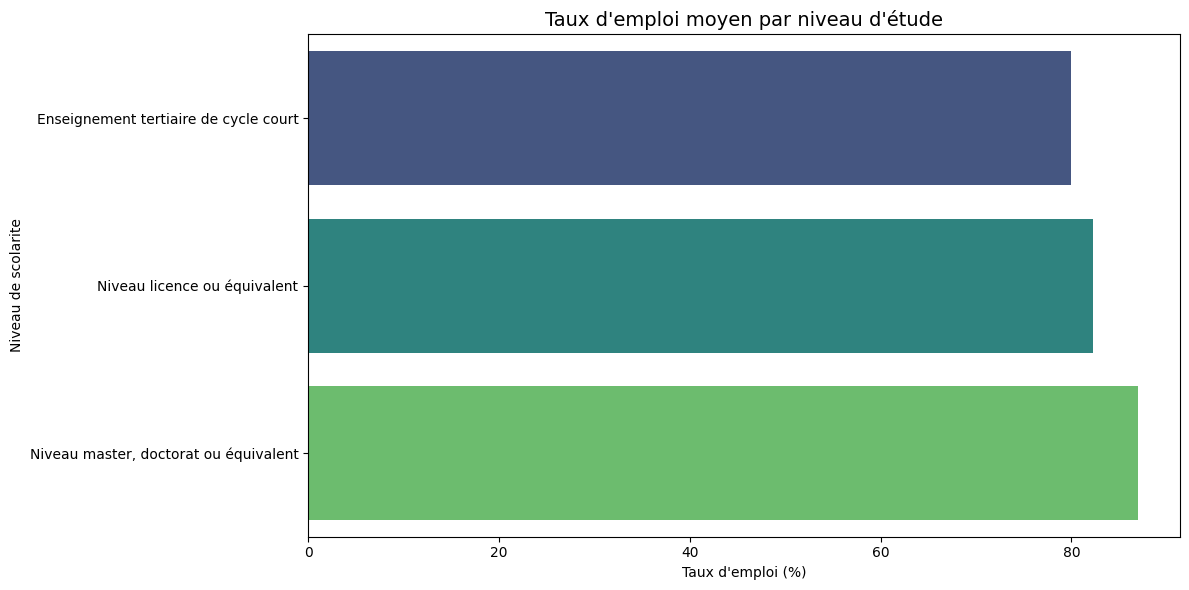

In [ ]:

emploi_par_niveau = (
    tauxChomEmploi.groupby('Niveau de scolarite')['taux emploi']
    .mean()
    .sort_index()
    .reset_index()
)

# Visualiser les données avec un diagramme en barres
plt.figure(figsize=(12, 6))
sns.barplot(data=emploi_par_niveau,
            x='taux emploi',
            y='Niveau de scolarite',
            palette='viridis')

plt.title("Taux d'emploi moyen par niveau d'étude", fontsize=14)
plt.xlabel("Taux d'emploi (%)")
plt.ylabel("Niveau de scolarite")
plt.tight_layout()
plt.show()




*   Le taux d'emploi moyen augmente avec le niveau d'études.
*   Les personnes ayant un niveau d'études plus élevé (Master, Doctorat ou équivalent) ont le taux d'emploi le plus élevé.


*  
Les personnes avec un niveau licence ont un taux d'emploi légèrement inférieur à celui des niveaux Master/Doctorat, mais supérieur à celui des études tertiaires de cycle court.
*   Élément de liste

Ce graphique montre une corrélation positive entre le niveau d'études et le taux d'emploi moyen. Les individus ayant des qualifications plus élevées (Master, Doctorat) semblent avoir de meilleures opportunités d'emploi,




**Visualisation de distribution de taux d'emploi selon le domaine d'étude**

<ipython-input-9-21094f876e91>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=emploi_par_domaine,


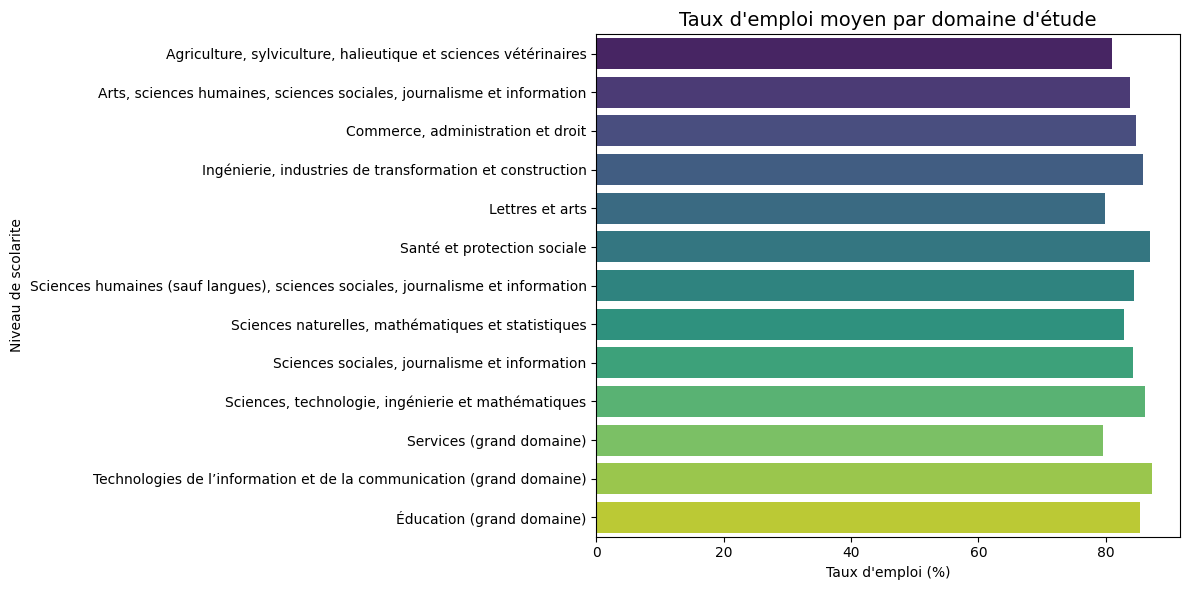

In [ ]:

emploi_par_domaine = (
    tauxChomEmploi.groupby('Domaine etudes')['taux emploi']
    .mean()
    .sort_index()
    .reset_index()
)

# Visualiser les données avec un diagramme en barres
plt.figure(figsize=(12, 6))
sns.barplot(data=emploi_par_domaine,
            x='taux emploi',
            y='Domaine etudes',
            palette='viridis')

plt.title("Taux d'emploi moyen par domaine d'étude", fontsize=14)
plt.xlabel("Taux d'emploi (%)")
plt.ylabel("Niveau de scolarite")
plt.tight_layout()
plt.show()



1.   Domaines avec les taux d'emploi les plus élevés :


*   Technologies de l’information et de la communication (grand domaine) suit de près, ce qui reflète la forte demande dans ce secteur.
*   Éducation (grand domaine) a le taux d'emploi le plus élevé parmi les domaines représentés.



2.   Domaines avec des taux d'emploi modérés :


*   
Les domaines comme services, sciences, technologie, ingénierie et mathématiques affichent des taux d'emploi compétitifs.
3.  
Domaines avec les taux d'emploi les plus faibles :


*   Les secteurs tels que agriculture, sylviculture, halieutique et sciences vétérinaires et arts, sciences humaines, sciences sociales, journalisme et information ont des taux d'emploi inférieurs comparés aux autres.








**Analyse de donnée de tauxEmploiChaumage :**

**Dans quelle mesure le taux de chômage impacte-t-il le taux d'emploi ?**

##On répond en appliquant la régression linéaire :

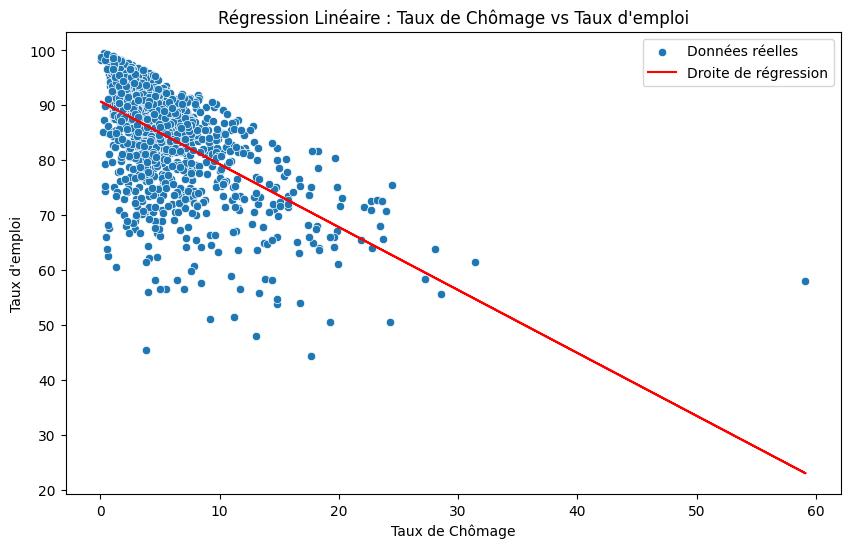

Coefficient de régression (pente) : -1.1459794550043112
Ordonnée à l'origine : 90.7302564292137
Score R^2 : 0.32586443443023394


In [ ]:

X = tauxChomEmploi[['Taux de Chomage']]  # Variable indépendante
y = tauxChomEmploi['taux emploi']       # Variable dépendante

# Créer une instance du modèle de régression linéaire
reg_model = LinearRegression()

# Entraîner le modèle
reg_model.fit(X, y)

# Prédire les valeurs de y basées sur le modèle
y_pred = reg_model.predict(X)

# Tracer le nuage de points et la droite de régression
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X['Taux de Chomage'], y=y, label='Données réelles')
plt.plot(X['Taux de Chomage'], y_pred, color='red', label='Droite de régression')

# Ajouter des titres et des labels
plt.title('Régression Linéaire : Taux de Chômage vs Taux d\'emploi')
plt.xlabel('Taux de Chômage')
plt.ylabel('Taux d\'emploi')
plt.legend()

# Afficher le graphique
plt.show()

# Afficher les coefficients du modèle
print(f"Coefficient de régression (pente) : {reg_model.coef_[0]}")
print(f"Ordonnée à l'origine : {reg_model.intercept_}")
print(f"Score R^2 : {r2_score(y, y_pred)}")


* Corrélation négative:

La pente de la droite est négative, indiquant qu'il existe une relation inverse entre le taux de chômage et le taux d'emploi. En d'autres termes, plus le taux de chômage est élevé, plus le taux d'emploi est faible.
Alignement des points :

* Les points sont globalement alignés le long de la droite de régression, ce qui suggère que la régression linéaire est un modèle raisonnable pour décrire cette relation. Cependant, il y a une certaine dispersion autour de la droite.

* Le
𝑅
  indique la proportion de la variance dans la variable dépendante (taux d'emploi) expliquée par la variable indépendante (taux de chômage).

* Un
𝑅
carré
  de 0.326 (ou 32.6 %) signifie que seulement environ 32.6 % de la variabilité du taux d'emploi est expliquée par le taux de chômage.
Ce score est relativement faible, ce qui suggère que d'autres facteurs non inclus dans le modèle influencent le taux d'emploi.



**Comment la dispersion des taux de chômage diffère-t-elle entre les différents niveaux d'études ?**

##On répond en appliquant **ANOVA** :

**Voir  la normalité :**

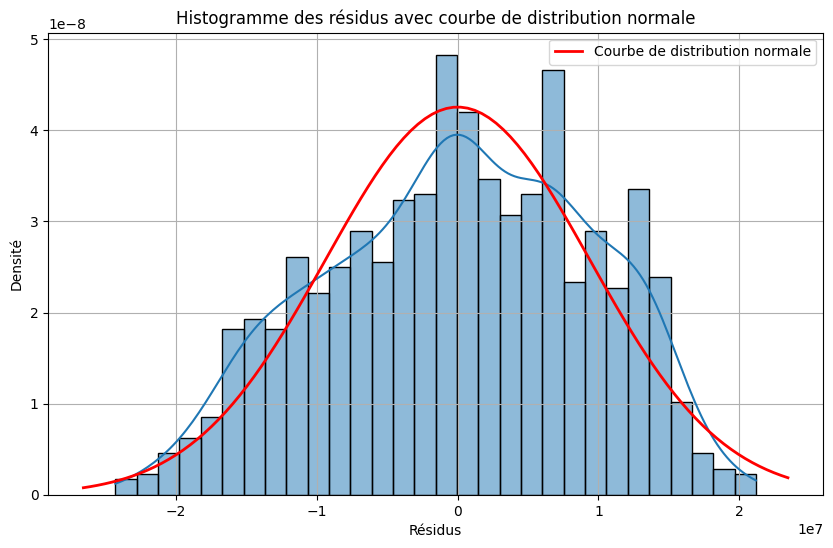

Shapiro-Wilk test après transformation logarithmique: W = 0.98452440987828 , p-value = 8.990888778297036e-10


In [ ]:
model = smf.ols('taux_emploi ~ C(Domaine_etudes)', data=df).fit()
residus = model.resid

# Créer l'histogramme des résidus
plt.figure(figsize=(10, 6))
sns.histplot(residus, kde=True, stat="density", bins=30)

# Ajouter une courbe de distribution normale
mu, std = stats.norm.fit(residus)
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = stats.norm.pdf(x, mu, std)  # PDF de la normale
plt.plot(x, p, 'r', linewidth=2, label='Courbe de distribution normale')

# Ajouter des titres et des labels
plt.title('Histogramme des résidus avec courbe de distribution normale')
plt.xlabel('Résidus')
plt.ylabel('Densité')
plt.legend()
plt.grid(True)

# Afficher le graphique
plt.show()


Donc la distribution des résidus est normale, ce qui est un bon signe pour la validité du modèle.

**Visualiser les différences  entre les niveaux études en fonction de taux de chomage et évaluer la dispersion des données**

<ipython-input-11-14bea7e1eb05>:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Niveau_de_scolarite', y='Taux_de_Chomage', palette='coolwarm')


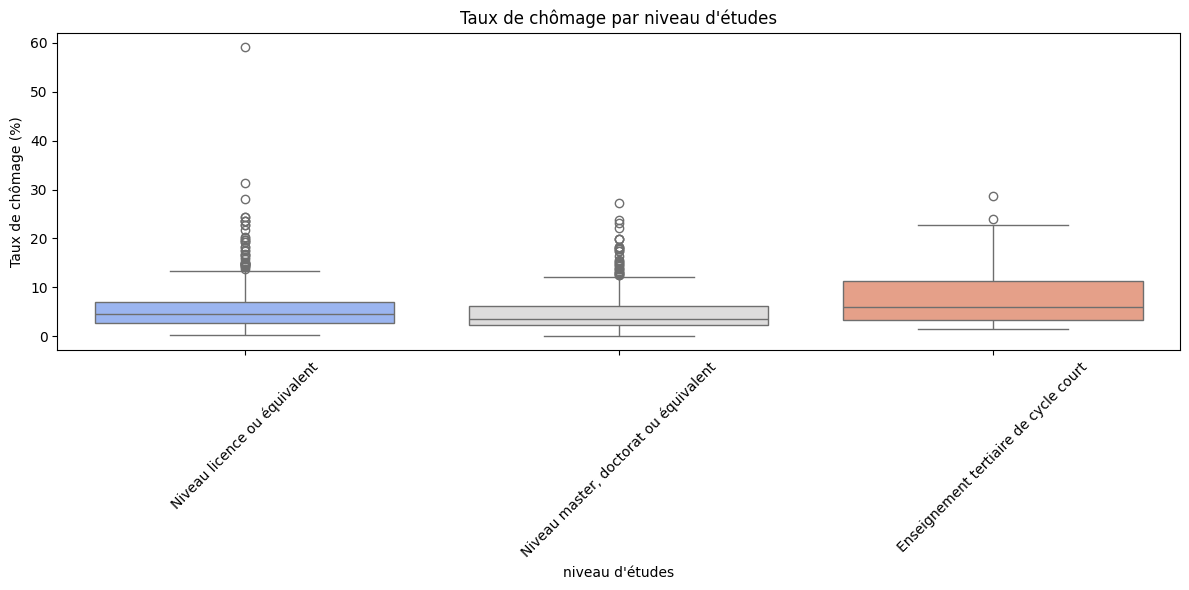

In [ ]:
df = tauxChomEmploi.rename(columns={
    'Taux de Chomage': 'Taux_de_Chomage',
    'Niveau de scolarite': 'Niveau_de_scolarite'
})

# ANOVA après renommage des colonnes
model = ols('Taux_de_Chomage ~ C(Niveau_de_scolarite)', data=df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)

# Visualisation des données
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='Niveau_de_scolarite', y='Taux_de_Chomage', palette='coolwarm')
plt.title("Taux de chômage par niveau d'études")
plt.xlabel("niveau d'études")
plt.ylabel("Taux de chômage (%)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



**Niveau master, doctorat ou équivalent :**

Boîte basse, médiane proche de Q1, moustaches courtes avec plusieurs valeurs aberrantes (ces valeurs aberrantes représentent des individus ou des sous-groupes dont le taux de chômage est exceptionnellement élevé par rapport à la majorité des données. )

Interprétation : Le taux de chômage est globalement faible, avec peu de variabilité. La plupart des individus de ce groupe ont un taux de chômage similaire.

**Niveau licence ou équivalent :**

Boîte plus haute, médiane au centre, moustaches modérées.

Interprétation : Le taux de chômage est plus élevé que pour le groupe précédent, avec une variabilité modérée. La distribution est symétrique. Certains individus de ce groupe ont des taux de chômage exceptionnellement élevés .

**Enseignement tertiaire de cycle court :**

Boîte très haute, médiane proche de Q3, moustaches longues avec plusieurs valeurs aberrantes.

Interprétation : Le taux de chômage est globalement élevé, avec une grande despertion.

##Lancer Anova :

In [ ]:
import statsmodels.formula.api as smf
anova_variete = smf.ols('Taux_de_Chomage~Niveau_de_scolarite', data=df).fit()
print(anova_variete.summary())

                            OLS Regression Results                            
Dep. Variable:        Taux_de_Chomage   R-squared:                       0.031
Model:                            OLS   Adj. R-squared:                  0.029
Method:                 Least Squares   F-statistic:                     18.34
Date:                Fri, 03 Jan 2025   Prob (F-statistic):           1.44e-08
Time:                        14:01:40   Log-Likelihood:                -3446.9
No. Observations:                1161   AIC:                             6900.
Df Residuals:                    1158   BIC:                             6915.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                                                                   coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------

**Interpretation :**

* Par le test de Fisher PR(>F) : La valeur p est de 1.44e-08, cette valeur extrêmement faible (< 0.05) indique qu'il y a une différence significative entre les niveaux d'études.
* Conclusion :
Les niveaux d'études influencent significativement le taux de chomage .


##Post-hoc test pour identifier les différences spécifiques :


In [ ]:
# Test Tukey HSD (test post hoc)
tukey_results = pairwise_tukeyhsd(
    df['Taux_de_Chomage'],  # La variable dépendante
    df['Niveau_de_scolarite']  # La variable de groupe
)

print("\nTukey HSD Results:")
print(tukey_results)



Tukey HSD Results:
                               Multiple Comparison of Means - Tukey HSD, FWER=0.05                                
                group1                                group2                meandiff p-adj   lower   upper  reject
------------------------------------------------------------------------------------------------------------------
Enseignement tertiaire de cycle court          Niveau licence ou équivalent  -2.1723 0.0002 -3.4544 -0.8902   True
Enseignement tertiaire de cycle court Niveau master, doctorat ou équivalent  -3.1279    0.0 -4.4047 -1.8511   True
         Niveau licence ou équivalent Niveau master, doctorat ou équivalent  -0.9556 0.0027 -1.6315 -0.2797   True
------------------------------------------------------------------------------------------------------------------


**Interpretation :**

1.   Enseignement tertiaire de cycle court vs Niveau licence ou équivalent :

Il y a une différence significative entre ces deux groupes. Le taux de chômage est plus élevé de 2.17 points dans le groupe "Enseignement tertiaire de cycle court" par rapport au groupe "Niveau licence ou équivalent".
2.   Enseignement tertiaire de cycle court vs Niveau master, doctorat ou équivalent :

Il y a une différence significative entre ces deux groupes. Le taux de chômage est plus élevé de 3.13 points dans le groupe "Enseignement tertiaire de cycle court" par rapport au groupe "Niveau master, doctorat ou équivalent".

3. Niveau licence ou équivalent vs Niveau master, doctorat ou équivalent :

Le taux de chômage est plus élevé de 0.96 point dans le groupe "Niveau licence ou équivalent" par rapport au groupe "Niveau master, doctorat ou équivalent".


Conclusion générale :

Le groupe "Enseignement tertiaire de cycle court" a un taux de chômage significativement plus élevé que les deux autres groupes ("Niveau licence ou équivalent" et "Niveau master, doctorat ou équivalent").

Le groupe "Niveau licence ou équivalent" a un taux de chômage significativement plus élevé que le groupe "Niveau master, doctorat ou équivalent".

##**Y a-t-il une forte variabilité du taux d'emploi selon les domaines d'études ?**

##Visualiser les différences  entre les domaines d'études en fonction de taux d'emploi et évaluer la dispersion des données


Domaines montrant une différence significative:


<ipython-input-26-2bb6de818e43>:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_significant, x='Domaine_etudes', y='taux_emploi', palette='coolwarm')


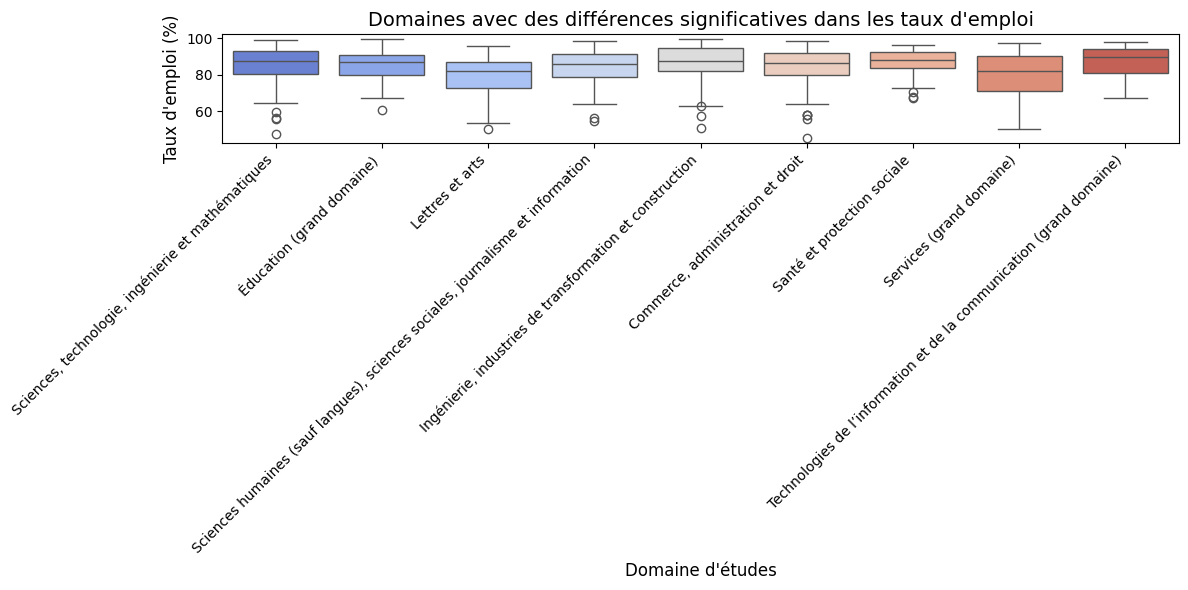

In [ ]:
df = tauxChomEmploi.rename(columns={
    'taux emploi': 'taux_emploi',
    'Domaine etudes': 'Domaine_etudes'
})

# Visualisation initiale des données pour tous les domaines
plt.figure(figsize=(14, 8))
sns.boxplot(data=df, x='Domaine_etudes', y='taux_emploi', palette='viridis')
plt.title("Taux d'emploi par domaine d'études (tous les domaines)", fontsize=16)
plt.xlabel("Domaine d'études", fontsize=12)
plt.ylabel("Taux d'emploi (%)", fontsize=12)
plt.xticks(rotation=45, fontsize=10, ha='right')
plt.tight_layout()
plt.show()


Voici une analyse détaillée pour chacun des 6 domaines présentés dans le boxplot :

1. Sciences, technologie, ingénierie et mathématiques (STIM)

* Médiane : Élevée, proche de 90 %, ce qui indique que la majorité des diplômés dans ce domaine trouvent un emploi.

* Étendue interquartile (IQR) : Relativement faible, ce qui signifie que les taux d'emploi sont assez homogènes.

* Valeurs extrêmes : Quelques outliers en dessous de 70 %, indiquant que certaines spécialisations ou régions peuvent poser des défis.

2. Éducation (grand domaine)

* Médiane : Relativement élevée, supérieure à 85 %.
* Étendue interquartile (IQR) : Moyenne, montrant une certaine variabilité dans les taux d'emploi selon les spécialités ou niveaux (éducation primaire, secondaire, etc.).
* Valeurs extrêmes : Plusieurs outliers sous 70 %, ce qui peut refléter des disparités régionales dans l'offre d'emplois éducatifs.

3. Ingénierie, industries de transformation et construction
Médiane : Très élevée, autour de 90 %.

* Étendue interquartile (IQR) : Faible, indiquant une grande cohérence des opportunités d'emploi dans ce domaine.
* Valeurs extrêmes : Quelques valeurs sous 80 %, mais très peu.

4. Commerce, administration et droit
* Médiane : Proche de 90 %, indiquant une bonne performance globale.
* Étendue interquartile (IQR) : Moyenne, reflétant une certaine hétérogénéité dans les résultats en fonction des sous-domaines (par exemple, droit vs administration).
* Valeurs extrêmes : Quelques outliers sous 70 %, ce qui peut correspondre à des spécialisations moins demandées.


5. Santé et protection sociale
* Médiane : Supérieure à 85 %, indiquant une performance globale solide.
* Étendue interquartile (IQR) : Assez large, montrant une plus grande dispersion dans les résultats d'emploi.
* Valeurs extrêmes : Plusieurs valeurs basses (inférieures à 70 %), ce qui pourrait être dû à des spécialisations très spécifiques ou à un manque de postes disponibles dans certaines régions.

6. Technologies de l'information et de la communication (grand domaine)
* Médiane : Très élevée, proche de 90 %, confirmant un marché de l'emploi solide.
* Étendue interquartile (IQR) : Très faible, ce qui indique une grande stabilité dans les opportunités d'emploi.
* Valeurs extrêmes : Quelques rares outliers en dessous de 80 %, probablement des cas isolés.


7. Lettres et arts

* Médiane : Inférieure à 85 %, indiquant une performance d’emploi plus faible par rapport à d’autres domaines.
* Étendue interquartile (IQR) : Moyenne à large, montrant une variabilité importante des taux d’emploi selon les spécialisations (arts plastiques, histoire de l’art, etc.).
* Valeurs extrêmes : Plusieurs outliers en dessous de 70 %, suggérant que certaines spécialisations artistiques sont moins demandées sur le marché de l’emploi.

8. Sciences humaines (sauf langues), sciences sociales, journalisme et information

* Médiane : Aux alentours de 85 %, ce qui reflète un taux d’emploi acceptable, mais légèrement en dessous de certains autres domaines.
* Étendue interquartile (IQR) : Moyenne, montrant une certaine hétérogénéité dans les résultats d’emploi selon les sous-domaines (sociologie, anthropologie, journalisme, etc.).
* Valeurs extrêmes : Plusieurs valeurs inférieures à 70 %, particulièrement dans des spécialisations moins populaires ou en demande.

9. Services (grand domaine)

* Médiane : Moyenne, avoisinant les 80 %, ce qui en fait l’un des domaines avec les taux d’emploi les plus bas.
* Étendue interquartile (IQR) : Large, illustrant une importante dispersion des résultats selon les spécialisations.
* Valeurs extrêmes : Nombreuses valeurs en dessous de 70 %, mettant en évidence des défis importants dans certaines branches (hôtellerie, restauration, etc.).

##Lançons Anova :

In [ ]:
anova_variete = smf.ols('taux_emploi~Domaine_etudes', data=df).fit()
print(anova_variete.summary())

                            OLS Regression Results                            
Dep. Variable:            taux_emploi   R-squared:                       0.044
Model:                            OLS   Adj. R-squared:                  0.034
Method:                 Least Squares   F-statistic:                     4.445
Date:                Fri, 03 Jan 2025   Prob (F-statistic):           5.34e-07
Time:                        14:21:46   Log-Likelihood:                -4247.7
No. Observations:                1161   AIC:                             8521.
Df Residuals:                    1148   BIC:                             8587.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                                                                                                        coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------



* Par le test de Fisher : On a p-value (PR(>F)) : 5.34×10−75.34×10 −7
   Cette valeur extrêmement faible (< 0.05) indique qu'il y a une différence significative entre les domaines d'études.

* Conclusion générale :
Donc les domaines d'études influencent significativement le taux d'emploi, en ligne avec les résultats de l'ANOVA.
Les domaines techniques et liés aux TIC (technologies de l'information) offrent généralement de meilleures opportunités, tandis que les filières artistiques et sociales présentent des défis plus importants pour l'intégration sur le marché du travail.




##Post-hoc test pour identifier les différences spécifiques :


In [ ]:
tukey_significant = pairwise_tukeyhsd(endog=df_significant['taux_emploi'],
                                      groups=df_significant['Domaine_etudes'],
                                      alpha=0.05)
print("\nTukey HSD Results :")
print(tukey_significant)


Tukey HSD Results :
                                                                          Multiple Comparison of Means - Tukey HSD, FWER=0.05                                                                          
                                     group1                                                                          group2                                     meandiff p-adj   lower    upper  reject
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
                                              Commerce, administration et droit                        Ingénierie, industries de transformation et construction    1.156 0.9859  -2.4407  4.7526  False
                                              Commerce, administration et droit                                                                 Lettres et arts  -4.9273 0.0029  -8

**Commerce, administration et droit vs. Lettres et arts :**

Différence de moyenne (meandiff) : -4.9273

Conclusion : La différence est statistiquement significative (reject = True). Le domaine des Lettres et arts a un taux d'emploi significativement plus élevé que celui du Commerce, administration et droit.

**Commerce, administration et droit vs. Services (grand domaine) :**

Différence de moyenne (meandiff) : -5.2493

Conclusion : La différence est statistiquement significative (reject = True). Le domaine des Services a un taux d'emploi significativement plus élevé que celui du Commerce, administration et droit.

**Ingénierie, industries de transformation et construction vs. Lettres et arts :**

Différence de moyenne (meandiff) : -6.0832


Conclusion : La différence est statistiquement significative (reject = True). Le domaine des Lettres et arts a un taux d'emploi significativement plus bas que celui de l'Ingénierie, industries de transformation et construction.

**Ingénierie, industries de transformation et construction vs. Services (grand domaine) :**

Différence de moyenne (meandiff) : -6.4053

Conclusion : La différence est statistiquement significative (reject = True). Le domaine des Services a un taux d'emploi significativement plus bas que celui de l'Ingénierie, industries de transformation et construction.

**Lettres et arts vs. Santé et protection sociale :**

Différence de moyenne (meandiff) : 7.1457


Conclusion : La différence est statistiquement significative (reject = True). Le domaine de la Santé et protection sociale a un taux d'emploi significativement plus élevé que celui des Lettres et arts.

**Lettres et arts vs. Sciences humaines (sauf langues), sciences sociales, journalisme et information :**

Différence de moyenne (meandiff) : 4.5701

Conclusion : La différence est statistiquement significative (reject = True). Le domaine des Sciences humaines a un taux d'emploi significativement plus élevé que celui des Lettres et arts.

**Lettres et arts vs. Sciences, technologie, ingénierie et mathématiques :**

Différence de moyenne (meandiff) : 6.2865


Conclusion : La différence est statistiquement significative (reject = True). Le domaine des STIM a un taux d'emploi significativement plus élevé que celui des Lettres et arts.

**Lettres et arts vs. Technologies de l’information et de la communication (grand domaine) :**

Différence de moyenne (meandiff) : 7.4712


Conclusion : La différence est statistiquement significative (reject = True). Le domaine des TIC a un taux d'emploi significativement plus élevé que celui des Lettres et arts.

**Lettres et arts vs. Éducation (grand domaine) :**

Différence de moyenne (meandiff) : 5.5558


Conclusion : La différence est statistiquement significative (reject = True). Le domaine de l'Éducation a un taux d'emploi significativement plus élevé que celui des Lettres et arts.

**Santé et protection sociale vs. Services (grand domaine) :**

Différence de moyenne (meandiff) : -7.4677


Conclusion : La différence est statistiquement significative (reject = True). Le domaine des Services a un taux d'emploi significativement plus bas que celui de la Santé et protection sociale.

**Sciences, technologie, ingénierie et mathématiques vs. Services (grand domaine) :**

Différence de moyenne (meandiff) : -6.6085



Conclusion : La différence est statistiquement significative (reject = True). Le domaine des Services a un taux d'emploi significativement plus bas que celui des STIM.

**Services (grand domaine) vs. Technologies de l’information et de la communication (grand domaine) :**

Différence de moyenne (meandiff) : 7.7932


Conclusion : La différence est statistiquement significative (reject = True). Le domaine des TIC a un taux d'emploi significativement plus élevé que celui des Services.

**Services (grand domaine) vs. Éducation (grand domaine) :**

Différence de moyenne (meandiff) : 5.8779



Conclusion : La différence est statistiquement significative (reject = True). Le domaine de l'Éducation a un taux d'emploi significativement plus élevé que celui des Services.

## 5. les données du dataset OCDE :

- Ce dataset contient des données socio-économiques et démographiques pour différents pays membres l'OCDE.
- Il fournit des indicateurs variés pour comparer les performances économiques, sociales et fiscales de ces pays.
- Chaque ligne représente un pays, et les colonnes contiennent des données sur des aspects comme les dépenses publiques, la fiscalité...

In [ ]:
df = pd.read_csv('ocde_DATA.csv')
df.head()

,STRUCTURE,STRUCTURE_ID,STRUCTURE_NAME,ACTION,LOCATION,Pays,INDICATOR,Indicateur,SUBJECT,Sujet,...,OBS_VALUE,Observation Value,OBS_STATUS,Observation Status,UNIT_MEASURE,Unit of Measures,UNIT_MULT,Multiplier,BASE_PER,Base reference period
0,DATAFLOW,OECD:DF_DP_LIVE(1.0),OECD Data Archive,I,AUS,Australie,NNI,Revenu national net,TOT,Total,...,1.303851e+06,NaN,A,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,DATAFLOW,OECD:DF_DP_LIVE(1.0),OECD Data Archive,I,HUN,Hongrie,GGEXP,Dépenses des administrations publiques,TOT,Total,...,4.835402e+01,NaN,A,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,DATAFLOW,OECD:DF_DP_LIVE(1.0),OECD Data Archive,I,LUX,Luxembourg,TAXPAYROLL,Impôt sur les salaires,TOT,Total,...,0.000000e+00,NaN,A,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,DATAFLOW,OECD:DF_DP_LIVE(1.0),OECD Data Archive,I,GRC,Grèce,TAXPAYROLL,Impôt sur les salaires,TOT,Total,...,0.000000e+00,NaN,A,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,DATAFLOW,OECD:DF_DP_LIVE(1.0),OECD Data Archive,I,GRC,Grèce,TAXPAYROLL,Impôt sur les salaires,TOT,Total,...,0.000000e+00,NaN,A,NaN,NaN,NaN,NaN,NaN,NaN,NaN


**Suppression des colonnes inutiles :**

In [ ]:
colonnes_a_supprimer = [
    'STRUCTURE', 'STRUCTURE_ID', 'STRUCTURE_NAME', 'ACTION', 'LOCATION',
    'SUBJECT', 'Sujet', 'FREQUENCY','UNIT_MEASURE','INDICATOR','MEASURE',
    'Fréquence', 'TIME_PERIOD','Temps','Observation Value','OBS_STATUS',
    'Observation Status', 'Unit of Measures', 'UNIT_MULT',
    'Stocks d\'IDE entrant par secteur d\’activité',
    'Stocks d\'IDE sortant par secteur d\’activité',
    'Multiplier', 'BASE_PER', 'Base reference period','Unit multiplier'
]

# Supprimer les colonnes inutiles
df_cleaned = df.drop(columns=colonnes_a_supprimer, errors='ignore')


# Sauvegarder le dataset nettoyé
df_cleaned.to_csv('ocde_DATA_nettoyé.csv', index=False)
df_cleaned.head()


,Pays,Indicateur,Mesure,Valeur
0,Australie,Revenu national net,Millions de dollars US,1.303851e+06
1,Hongrie,Dépenses des administrations publiques,% du PIB,4.835402e+01
2,Luxembourg,Impôt sur les salaires,% du PIB,0.000000e+00
3,Grèce,Impôt sur les salaires,% des recettes fiscales,0.000000e+00
4,Grèce,Impôt sur les salaires,% du PIB,0.000000e+00


**Renommage des colonnes :**

In [ ]:
df_cleaned = df_cleaned.rename(columns={
    'OBS_VALUE': 'Valeur'
})

print(df_cleaned.head())

# Sauvegarder le dataset
df_cleaned.to_csv('ocde_DATA_nettoyé_Renommé.csv', index=False)


         Pays                              Indicateur  \
0   Australie                     Revenu national net   
1     Hongrie  Dépenses des administrations publiques   
2  Luxembourg                  Impôt sur les salaires   
3       Grèce                  Impôt sur les salaires   
4       Grèce                  Impôt sur les salaires   

                    Mesure        Valeur  
0   Millions de dollars US  1.303851e+06  
1                 % du PIB  4.835402e+01  
2                 % du PIB  0.000000e+00  
3  % des recettes fiscales  0.000000e+00  
4                 % du PIB  0.000000e+00  


**Pivotement des indicateurs en colonnes :**

In [ ]:
df = pd.read_csv('ocde_DATA_nettoyé_Renommé.csv')

# Pivotement
df_pivot = df.pivot_table(index='Pays', columns='Indicateur', values='Valeur', aggfunc='first')
df_pivot.reset_index(inplace=True)

# Sauvegarder le résultat
df_pivot.to_csv('DATA_OCDE_transformed.csv', index=False)


In [ ]:
df_pivot = pd.read_csv('DATA_OCDE_transformed.csv')
df_pivot.head()

,Pays,Dépenses des administrations publiques,Espérance de vie à la naissance,Heures travaillées,Impôt sur le revenu des personnes physiques,Impôt sur les biens et services,Impôt sur les bénéfices des sociétés,Impôt sur les salaires,Indices des niveaux de prix,Informatique à domicile,...,Produit intérieur brut (PIB),Recettes des administrations publiques,Recettes fiscales,Revenu national net,Rémunération horaire,Taux d'accès Internet,Taux d'emploi,Taux de mortalité infantile,Taux de pauvreté,Taux de suicide
0,Allemagne,51.030394,80.8,1340.165629,26.642,10.465,5.997,0.000,100.0,NaN,...,6.193981e+04,27944.470000,1682.006,5.227903e+04,0.591476,91.8750,75.600,3.0,NaN,NaN
1,Australie,41.055219,83.3,1694.799343,39.003,6.863,6.636,1.274,125.0,NaN,...,1.649096e+06,22017.520000,29.482,1.303851e+06,NaN,NaN,13045.730,3.3,NaN,12.4
2,Autriche,33627.870000,81.3,1439.093920,9.700,26.743,2.750,2.794,103.0,NaN,...,5.679881e+05,50.391071,43.284,1.055664e+02,119.639418,95.0006,72.400,2.7,0.098,11.0
3,Belgique,32607.620000,81.9,1525.815277,26.686,25.236,8.983,0.002,100.0,NaN,...,6.207716e+04,29381.090000,252.689,5.886212e+05,0.415288,92.2999,65.300,2.9,0.078,NaN
4,Canada,24748.550000,81.6,1685.000000,36.319,7.273,13.482,2.211,114.0,NaN,...,2.126696e+06,42.293369,679.059,1.150369e+02,117.694806,92.8000,73.475,NaN,0.105,NaN


**Calcul du pourcentage des valeurs manquantes pour chaque colonne :**

In [ ]:
missing_percentage = df_pivot.isnull().mean() * 100

# Identifier les colonnes avec plus de 50 % de valeurs manquantes
columns_to_drop = missing_percentage[missing_percentage > 50].index

# Afficher les colonnes identifiées
print("Colonnes avec plus de 50 % de valeurs manquantes :", columns_to_drop.tolist())


Colonnes avec plus de 50 % de valeurs manquantes : ['Informatique à domicile', 'Taux de suicide']


**Suppression des colonnes  avec plus de 50 % de valeurs manquantes :**

In [ ]:
df_cleaned = df_pivot.drop(columns=colonnes_a_supprimer, errors='ignore')


# Sauvegarder le dataset nettoyé
df_cleaned.to_csv('DATA_OCDE_transformed3.csv', index=False)

In [ ]:
df = pd.read_csv('DATA_OCDE_transformed3.csv')
df.head()


,Pays,Dépenses des administrations publiques,Espérance de vie à la naissance,Heures travaillées,Impôt sur le revenu des personnes physiques,Impôt sur les biens et services,Impôt sur les bénéfices des sociétés,Impôt sur les salaires,Indices des niveaux de prix,Population active,Population d'âge actif,Produit intérieur brut (PIB),Recettes des administrations publiques,Recettes fiscales,Revenu national net,Rémunération horaire,Taux d'accès Internet,Taux d'emploi,Taux de mortalité infantile,Taux de pauvreté
0,Allemagne,51.030394,80.8,1340.165629,26.642,10.465,5.997,0.000,100.0,42960.63,64.065092,5153144.247,27944.470000,1682.006,5.227903e+04,0.591476,91.8750,75.60000,3.0,NaN
1,Australie,41.055219,83.3,1694.799343,39.003,6.863,6.636,1.274,125.0,13738.09,64.713578,1649096.430,22017.520000,490.717,1.303851e+06,NaN,NaN,74.92894,3.3,NaN
2,Autriche,33627.870000,81.3,1439.093920,9.700,26.743,2.750,2.794,103.0,4589.60,66.257239,567988.073,50.391071,207.907,1.055664e+02,119.639418,95.0006,72.40000,2.7,0.098
3,Belgique,32607.620000,81.9,1525.815277,26.686,25.236,8.983,0.002,100.0,5178.05,63.850816,719586.058,29381.090000,252.689,5.886212e+05,0.415288,92.2999,65.30000,2.9,0.078
4,Canada,24748.550000,81.6,1685.000000,36.319,7.273,13.482,2.211,114.0,20484.15,65.721111,2126695.672,42.293369,679.059,1.150369e+02,117.694806,92.8000,73.47500,NaN,0.105


**Explication des colonnes :**
- **Pays :** Le nom du pays observé.
- **Produit intérieur brut (PIB) :** Valeur totale des biens et services produits par un pays, en Millions de dollars US.
- **Recettes fiscales :** Les revenus fiscaux (impôts, taxes) collectés par l'État en Millions de dollars US.
- **Population active :** Nombre total de personnes dans la population active , en milliers de personnes.
- **Population d'âge actif :** Population en âge de travailler, en Milliers de personnes.
- **Taux d'emploi :** le taux de la population active qui est employée, en Milliers de personnes
- **Taux de pauvreté :** taux de la population vivant sous le seuil de pauvreté, en Ratio
- **Dépenses des administrations publiques :** Les dépenses totales des gouvernements en pourcentage du PIB.
- **Revenu national net :** La somme des revenus perçus par les résidents d'un pays en Millions de dollars US.
- **Espérance de vie à la naissance :** L'espérance de vie moyenne, en années, d'une personne à sa naissance.
- **Heures travaillées :** Le nombre moyen d'heures travaillées par an par un travailleur(Heures/travailleur).
- **Impôt sur le revenu des personnes physiques :** Le pourcentage moyen d'impôts sur le revenu des individus, exprimé en % du PIB.
- **Impôt sur les biens et services :** Le pourcentage moyen d'impôts prélevés sur la consommation (TVA, taxes sur les biens et services), éxprimé en % du PIB.
- **Impôt sur les bénéfices des sociétés :** Le pourcentage d'imposition sur les bénéfices des entreprises, en % du PIB.
- **Impôt sur les salaires :** Les prélèvements obligatoires sur les salaires des travailleurs, exprimés en pourcentage.
- **Indices des niveaux de prix :** Un indice comparatif des niveaux de prix (valeur de 100 pour la moyenne des pays de référence).
- **Recettes des administrations publiques :** Les revenus totaux des gouvernements (en pourcentage du PIB).
- **Rémunération horaire :** Salaire moyen par heure travaillée, en % du taux de croissance annuel.
- **Taux d'accès Internet :** Pourcentage de la population ayant accès à Internet, en % de tous les ménages.
- **Taux de mortalité infantile :** Nombre de décès d'enfants pour 1 000 naissances vivantes.


In [ ]:
# Afficher les pays existants dans le dataset
pays_existants = df['Pays'].unique()
print(pays_existants)


['Allemagne' 'Australie' 'Autriche' 'Belgique' 'Canada' 'Chili' 'Colombie'
 'Corée' 'Costa Rica' 'Danemark' 'Espagne' 'Estonie' 'Finlande' 'France'
 'Grèce' 'Hongrie' 'Irlande' 'Islande' 'Italie' 'Japon' 'Lettonie'
 'Lituanie' 'Luxembourg' 'Mexique' 'Norvège' 'Nouvelle-Zélande' 'Pays-Bas'
 'Pologne' 'Portugal' 'Royaume-Uni' 'République slovaque' 'Slovénie'
 'Suisse' 'Suède' 'Tchéquie' 'Türkiye' 'États-Unis']


**Analyse exploratoire :**

In [ ]:
# Liste des indicateurs
indicateurs = [
    'Dépenses des administrations publiques',
    'Population active',
    'Population d\'âge actif',
    'Produit intérieur brut (PIB)',
    'Recettes fiscales',
    'Revenu national net',
    'Taux d\'emploi',
    'Taux de pauvreté',
]

# Calcul des statistiques pour chaque indicateur
for indicateur in indicateurs:
    if indicateur in df.columns:
        print(f"\nStatistiques pour '{indicateur}':")
        print(f" - Moyenne : {df[indicateur].mean()}")
        print(f" - Médiane : {df[indicateur].median()}")
        print(f" - Écart type : {df[indicateur].std()}")
        print(f" - Valeur minimale : {df[indicateur].min()}")
        print(f" - Valeur maximale : {df[indicateur].max()}")
    else:
        print(f"\nL'indicateur '{indicateur}' est absent du dataset.")



Statistiques pour 'Dépenses des administrations publiques':
 - Moyenne : 10281.267854975069
 - Médiane : 52.5728418681797
 - Écart type : 15192.603357090045
 - Valeur minimale : 24.377246383575
 - Valeur maximale : 56356.78

Statistiques pour 'Population active':
 - Moyenne : 17896.84091891892
 - Médiane : 5178.05
 - Écart type : 29371.14634307464
 - Valeur minimale : 209.675
 - Valeur maximale : 161203.9

Statistiques pour 'Population d'âge actif':
 - Moyenne : 65.0850244811642
 - Médiane : 65.0129203277523
 - Écart type : 2.3830505775727064
 - Valeur minimale : 59.3644649830692
 - Valeur maximale : 71.5624383755408

Statistiques pour 'Produit intérieur brut (PIB)':
 - Moyenne : 1869446.7189729728
 - Médiane : 574387.948
 - Écart type : 3897328.180970682
 - Valeur minimale : 22903.075
 - Valeur maximale : 23315081.0

Statistiques pour 'Recettes fiscales':
 - Moyenne : 498.79840540540533
 - Médiane : 192.366
 - Écart type : 1056.9483686687208
 - Valeur minimale : 8.978
 - Valeur maxim

**Interprétation :**
  - Les indicateurs, comme le PIB, les dépenses publiques ou le revenu national net, présentent des écarts très élevés entre pays, indiquant des inégalités significatives entre pays.
  - Des indicateurs sociaux comme la population d'âge actif, le taux d'emploi et le taux de pauvreté sont plus homogènes, reflétant des tendances globales similaires.s.

**Recettes fiscales par pays :**

C:\Users\dell\AppData\Local\Temp\ipykernel_5564\304133065.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x='Pays', y='Recettes fiscales', palette='viridis')


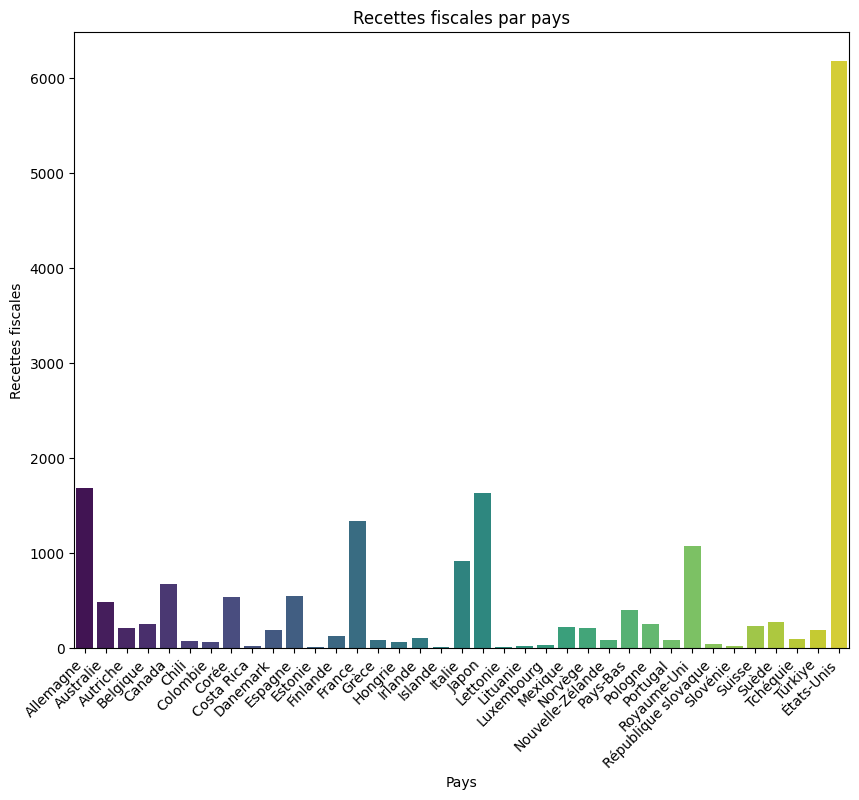

In [ ]:

plt.figure(figsize=(10, 8))
sns.barplot(data=df, x='Pays', y='Recettes fiscales', palette='viridis')
plt.xticks(rotation=45, ha='right')
plt.title("Recettes fiscales par pays")
plt.ylabel("Recettes fiscales")
plt.xlabel("Pays")
plt.show()


**Interprétation :**
- La taille des recettes fiscales est souvent corrélée à la taille de l'économie et à la population d'un pays, ainsi qu'à ses politiques fiscales.
- Les États-Unis ont des recettes fiscales exceptionnellement élevées par rapport aux autres pays.
- Cela reflète l'importance de leur économie, la taille de leur population, et leur système fiscal.
- Certains pays comme la France, le Japon et l'Allemagne ont des recettes fiscales significatives.
- Des pays comme la Colombie, l'Estonie, Islande ou la Slovénie ont des recettes fiscales beaucoup plus faibles, ce qui peut s'expliquer par des populations plus petites ou des économies moins développées.

**Analyse des données :**

**Existe-t-il une relation entre les recettes fiscales et le PIB ?**

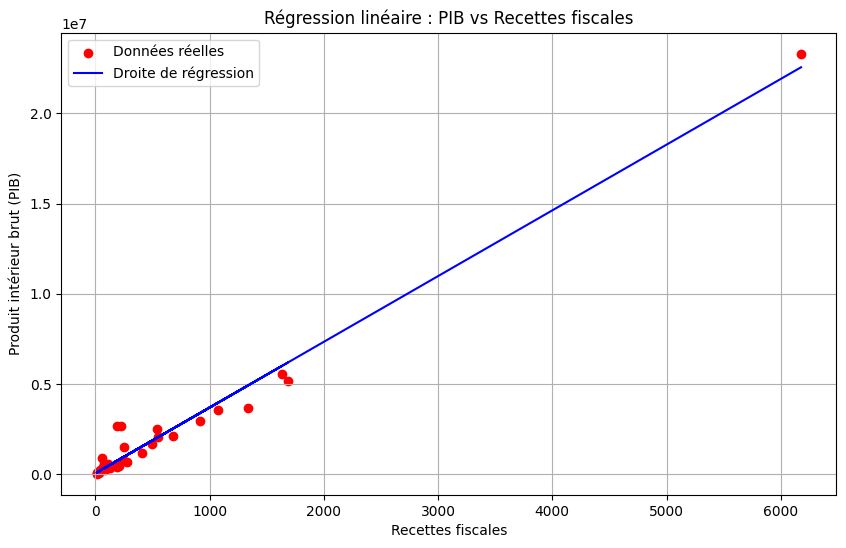

In [ ]:
y = df['Produit intérieur brut (PIB)']
X = df[['Recettes fiscales']]

X_const = sm.add_constant(X)

model = sm.OLS(y, X_const).fit()

y_pred = model.predict(X_const)

plt.figure(figsize=(10, 6))

plt.scatter(X, y, color='red', label='Données réelles')

plt.plot(X, y_pred, color='blue', label='Droite de régression')

plt.xlabel('Recettes fiscales')
plt.ylabel('Produit intérieur brut (PIB)')
plt.title('Régression linéaire : PIB vs Recettes fiscales')
plt.legend()
plt.grid()

plt.show()


**Interprétation :**

- Il existe une relation positive entre les recettes fiscales et le PIB : lorsque les recettes fiscales augmentent, le PIB tend également à augmenter.
- le groupe concentré montre une tendance générale dans les valeurs des PIB et recettes fiscales.
- La valeur extrême représente une observation particulière où les recettes fiscales et le PIB sont tous deux très élevés.

- **Quelles sont les relations entre les différentes variables démographiques ?**
- **Y a-t-il des groupes de pays ayant des profils démographiques similaires ?**
- **Comment les pays se positionnent-ils les uns par rapport aux autres en termes de données démographiques ?**

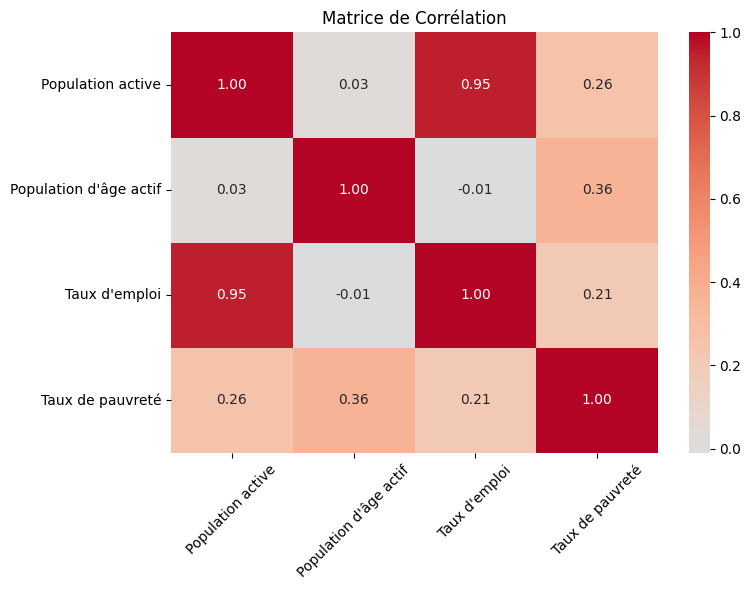

In [ ]:
# Sélection des variables démographiques
demo_vars = ['Population active', 'Population d\'âge actif', 'Taux d\'emploi', 'Taux de pauvreté']
df_cleaned = df[demo_vars].dropna()

# Étape 1 : centrage-réduction des données
df_cleaned = df[demo_vars].dropna()
scaler = StandardScaler()
demo_data_scaled = scaler.fit_transform(df_cleaned)

# Étape 2 : Matrice de Corrélation
corr_matrix = np.corrcoef(demo_data_scaled.T)
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix,
            annot=True,
            cmap="coolwarm",
            center=0,
            fmt=".2f",
            xticklabels=demo_vars,
            yticklabels=demo_vars)
plt.title("Matrice de Corrélation")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


**Interprétation :**

- **Population d'âge actif & Taux d'emploi** : Corrélation positive forte; cela indique que plus la population active est importante, plus le taux d'emploi est élevé. Cela reflète une relation logique entre ces deux variables.
- **Population active & Taux de pauvreté** : Corrélation faible et positive. Une augmentation de la population active est légèrement associée à une augmentation du taux de pauvreté.
- **Population d'âge actif & Taux de pauvreté** : Corrélation positive modérée. Une augmentation de la population d'âge actif est associée à une augmentation modérée du taux de pauvreté.
- Les autres variables montrent des corrélations faibles .

In [ ]:
# Étape 3 : Initialisation de l'ACP
pca = PCA(n_components=len(demo_vars))
demo_data_pca = pca.fit_transform(demo_data_scaled)

In [ ]:
# Étape 4 : Proportions de variance expliquée
explained_variance_ratio = pca.explained_variance_ratio_

print("Proportion de variance expliquée par chaque composante principale :")
for i, ratio in enumerate(explained_variance_ratio, 1):
    print(f"Composante {i}: {ratio:.2%}")


Proportion de variance expliquée par chaque composante principale :
Composante 1: 44.56%
Composante 2: 24.82%
Composante 3: 19.24%
Composante 4: 11.38%


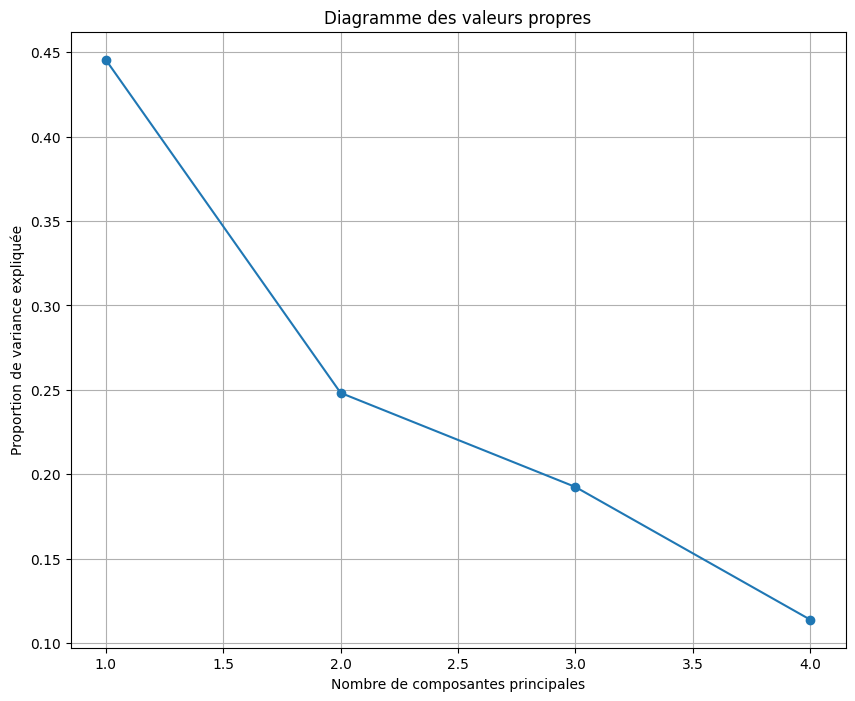

In [ ]:
# Étape 5 : Tracé du diagramme des valeurs propres
plt.figure(figsize=(10, 8))
plt.plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, marker='o', linestyle='-')
plt.xlabel('Nombre de composantes principales')
plt.ylabel('Proportion de variance expliquée')
plt.title('Diagramme des valeurs propres')
plt.grid()
plt.show()

**Interprétation :**
- Le graphique montre un "coude" après la deuxième composante. Cela indique que les deux premières composantes principales sont les plus importantes pour expliquer la majorité de la variance dans les données (ils expliquent 69.38% de la variance totale).

Liste des pays utilisés : ['Autriche', 'Belgique', 'Canada', 'Corée', 'Costa Rica', 'Espagne', 'Estonie', 'Finlande', 'France', 'Grèce', 'Hongrie', 'Irlande', 'Italie', 'Lettonie', 'Lituanie', 'Luxembourg', 'Norvège', 'Pays-Bas', 'Pologne', 'Portugal', 'Royaume-Uni', 'République slovaque', 'Slovénie', 'Suède', 'Tchéquie', 'États-Unis']


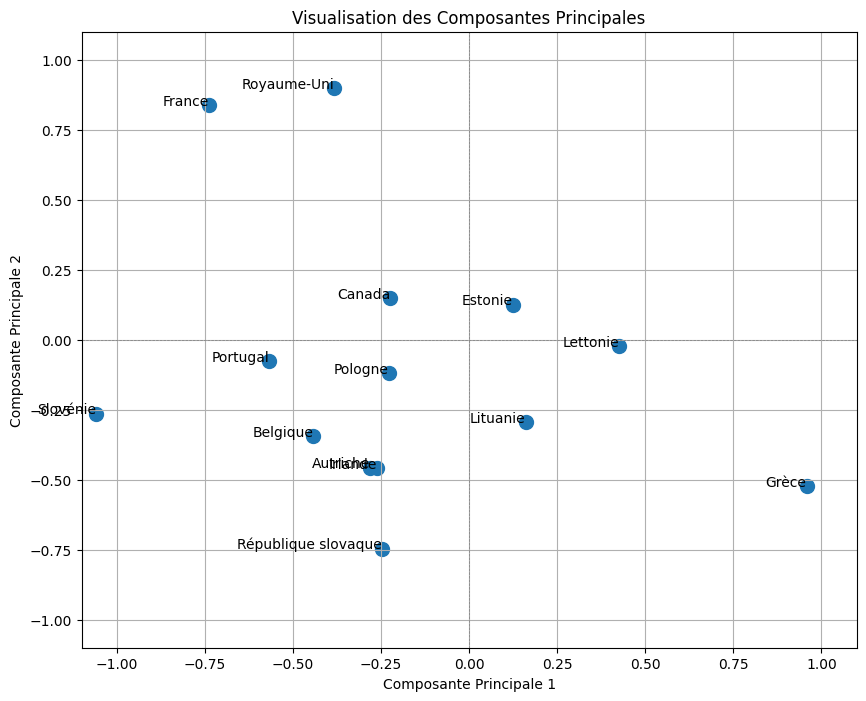

In [ ]:
# Étape 6 : Visualisation des composantes principales avec les noms des pays
plt.figure(figsize=(10, 8))
plt.scatter(demo_data_pca[:, 0], demo_data_pca[:, 1], s=100)
pays_utilises = df['Pays'].iloc[df_cleaned.index].tolist()
print("Liste des pays utilisés :", pays_utilises)

for i in range(len(df_cleaned)):
    plt.annotate(df['Pays'].iloc[df_cleaned.index[i]],
                 (demo_data_pca[i, 0], demo_data_pca[i, 1]),
                 fontsize=10, ha='right')

plt.xlim(-1.1, 1.1)
plt.ylim(-1.1, 1.1)
plt.xlabel('Composante Principale 1')
plt.ylabel('Composante Principale 2')
plt.title('Visualisation des Composantes Principales')
plt.grid()
plt.axhline(0, color='gray', linestyle='--', linewidth=0.5)
plt.axvline(0, color='gray', linestyle='--', linewidth=0.5)
plt.show()


**Interprétation :**
- Les pays proches les uns des autres dans le graphique ont des profils similaires en termes des variables démographiques.
- La France, Royaume-Unis,Slovénie et la Grèce se démarquent des autres pays, suggérant un profil démographiques différent.


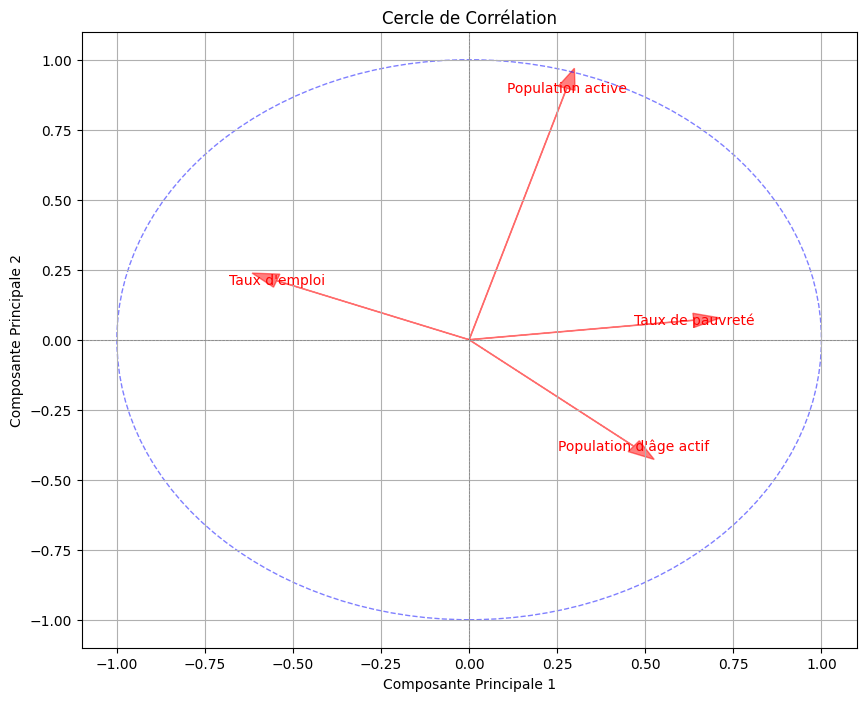

In [ ]:
from sklearn.decomposition import PCA
# Étape 7 : Ajout du cercle de corrélation
components = pca.components_
components_to_plot = components.T[:, :2]

plt.figure(figsize=(10, 8))
for i, (x, y) in enumerate(components_to_plot):
    plt.arrow(0, 0, x, y, color='r', alpha=0.5, head_width=0.05)
    plt.text(x, y, demo_vars[i], color='r', ha='center', va='center')

circle = plt.Circle((0, 0), 1, color='b', fill=False, linestyle='--', alpha=0.5)
plt.gca().add_artist(circle)

plt.xlim(-1.1, 1.1)
plt.ylim(-1.1, 1.1)
plt.xlabel('Composante Principale 1')
plt.ylabel('Composante Principale 2')
plt.title('Cercle de Corrélation')
plt.grid()
plt.axhline(0, color='gray', linestyle='--', linewidth=0.5)
plt.axvline(0, color='gray', linestyle='--', linewidth=0.5)
plt.show()

#Le cercle de corrélation permet d'identifier  les relations entre les variables,ce qui aide à comprendre quels facteurs démographiques influencent le plus les différences entre les pays.

**Interprétation :**
- La population active influencent fortement la 2ème composante.
- Le taux de pauvreté indique une forte corrélation positive avec CP1.
- Le taux de pauvreté et la population d’âge actif sont corrélés.
- Population d’âge actif et taux d’emploi  forment une corrélation négative faible à modérée.


**Quels sont les groupes de pays ayant des profils économiques similaires ?**

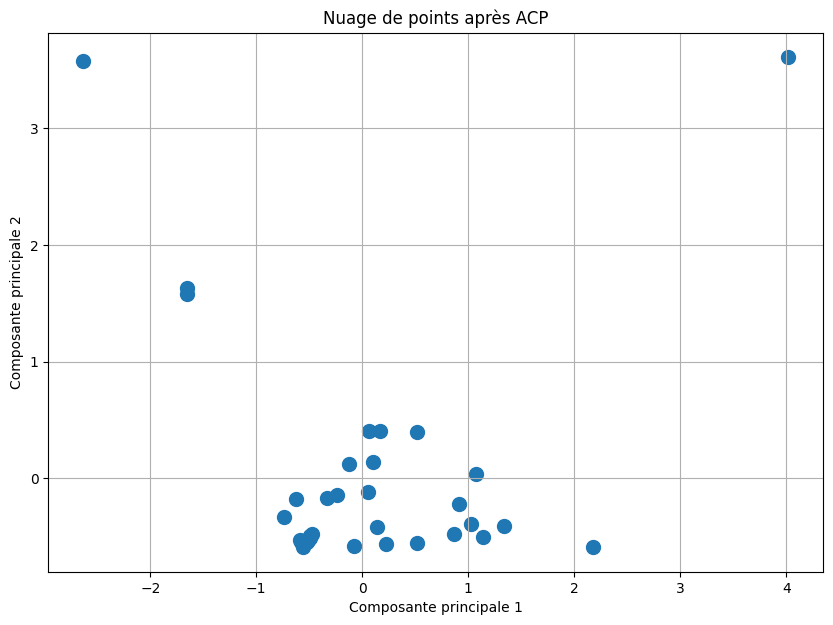

In [ ]:
selected_columns = ['Dépenses des administrations publiques',
                    'Produit intérieur brut (PIB)',
                    'Revenu national net']

selected_data = df[selected_columns]

selected_data = selected_data.fillna(selected_data.mean())

scaler = StandardScaler()
selected_data_scaled = scaler.fit_transform(selected_data)

pca = PCA(n_components=2)
selected_data_pca = pca.fit_transform(selected_data_scaled)

plt.figure(figsize=(10, 7))
plt.scatter(selected_data_pca[:, 0], selected_data_pca[:, 1], s=100)
plt.title("Nuage de points après ACP")
plt.xlabel("Composante principale 1")
plt.ylabel("Composante principale 2")
plt.grid()
plt.show()


**Interprétation :**
- Les pays regroupés ensemble peuvent partager des caractéristiques démographiques similaires.
- On peut distinguer 4 groupes de données, c'est a dire que les pays peuvent être regroupés en fonction de leur

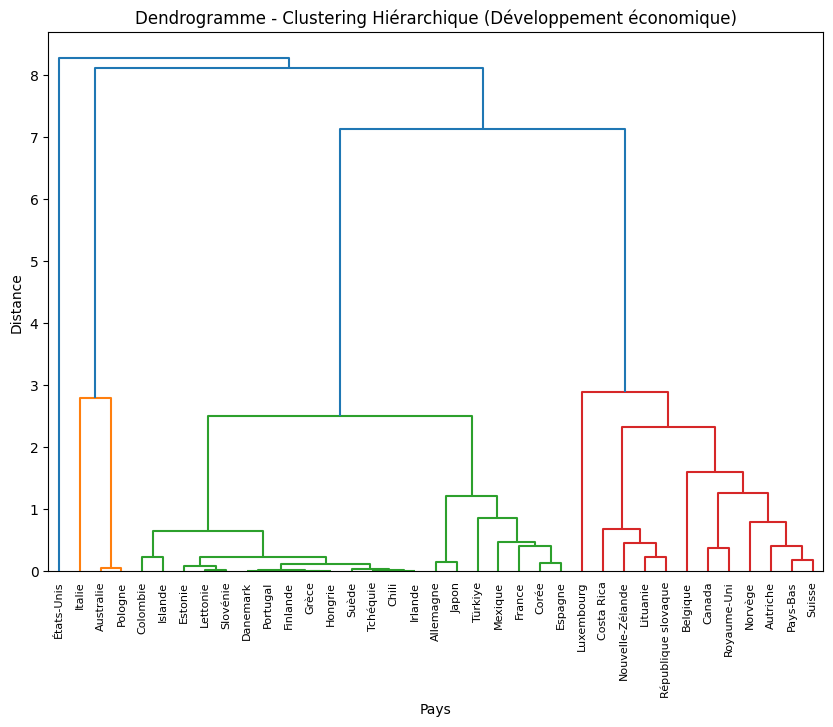

In [ ]:
# Clustering hiérarchique
linked = linkage(selected_data_scaled, method='ward')

plt.figure(figsize=(10, 7))
plt.title("Dendrogramme - Clustering Hiérarchique (Développement économique)")
dendrogram(linked, labels=df['Pays'].tolist(), leaf_rotation=90)
plt.xlabel("Pays")
plt.ylabel("Distance")
plt.show()

**Interprétation :**
- Les pays les plus similaires apparaissent connectés par des branches proches.Comme dans le
    - Cluster Rouge : qui semble contenir des pays avec des caractéristiques socio-économiques similaires, suggérant qu'ils partagent des niveaux de développement comparables.
    - Cluster Vert : qui représente des pays avec des différences marquées, mais qui sont encore plus similaires entre eux.
    - Cluster Orange : étant plus éloigné des autres, pourrait représenter des pays avec des caractéristiques socio-économiques très distinctes.
- La grande distance entre les États-Unis et les autres branches suggère que les différences sont significatives

Trouver un nombre intéressant de clusters dans un dendrogramme revient à identifier l'espace où les lignes verticales sont les plus longues. Cela indique une séparation plus marquée entre les clusters.

On peut tracer une ligne horizontale qui passe par cette distance maximale :

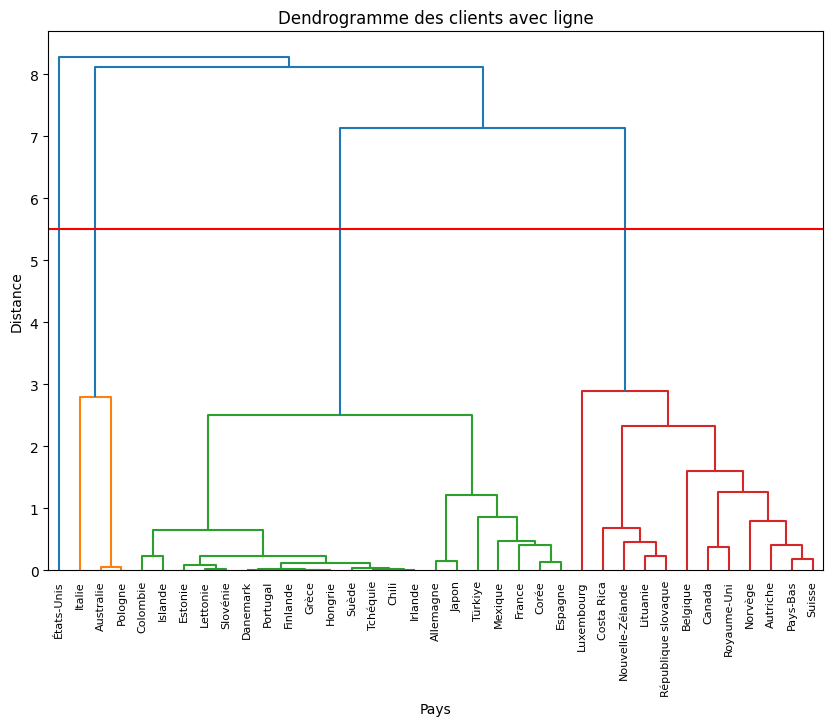

In [ ]:
## Determination des clusters :
plt.figure(figsize=(10, 7))
plt.title("Dendrogramme des clients avec ligne")
clusters = shc.linkage(selected_data_scaled, method='ward', metric="euclidean")
shc.dendrogram(clusters, labels=df['Pays'].tolist(), leaf_rotation=90)
plt.axhline(y=5.5, color='r', linestyle='-')
plt.xlabel("Pays")
plt.ylabel("Distance")
plt.show()


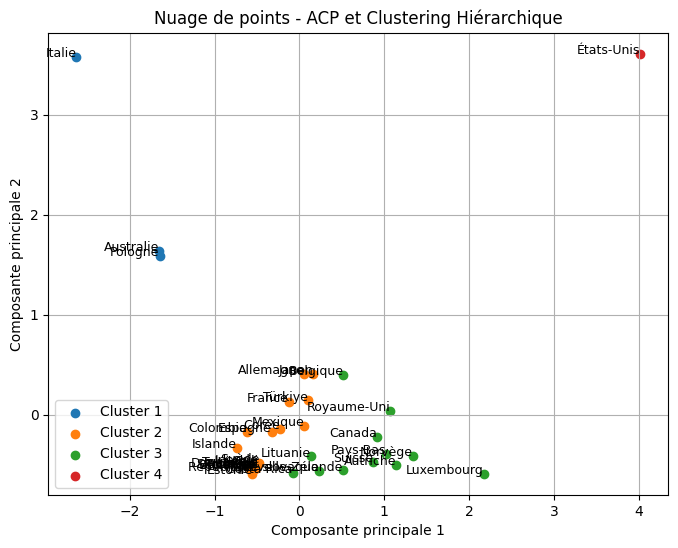

In [ ]:
num_clusters = 4
clusters_hierarchical = fcluster(linked, num_clusters, criterion='maxclust')

df['Cluster_Hierarchical'] = clusters_hierarchical

# Visualisation des clusters avec ACP
plt.figure(figsize=(8, 6))
for cluster in range(1, num_clusters + 1):
    cluster_data = selected_data_pca[clusters_hierarchical == cluster]
    plt.scatter(cluster_data[:, 0], cluster_data[:, 1], label=f'Cluster {cluster}')

    for i in range(len(cluster_data)):
        plt.annotate(df['Pays'][clusters_hierarchical == cluster].iloc[i],
                     (cluster_data[i, 0], cluster_data[i, 1]),
                     fontsize=9, ha='right')

plt.title("Nuage de points - ACP et Clustering Hiérarchique")
plt.xlabel("Composante principale 1")
plt.ylabel("Composante principale 2")
plt.legend()
plt.grid()
plt.show()


**Interprétation :**

- Les pays dans le même cluster pourraient avoir des politiques fiscales et des structures économiques comparables. 
- La dispersion des points peut indiquer une variabilité dans les politiques fiscales et les performances économiques entre les pays.



## **3- World Bank API** :
## **Économie, Éducation et Emploi : Analyse des Indicateurs Mondiaux:**

**Le jeu de donnée étudié regroupe des données de 190 pays pour l'année 2021, issues de l'API de la Banque mondiale. Il inclut des indicateurs économiques (PIB par habitant, emploi vulnérable), éducatifs (taux de scolarisation, dépenses en éducation) et sociaux (dépenses en santé), permettant d'explorer leurs relations avec l'Indice de Développement Humain (IDH).**

### Nettoyage des données :

**Récupération des données**

In [ ]:
# Année cible
year = "2021"

# Indicateurs par domaine
indicators = {
    "economic": {
        "NY.GDP.PCAP.PP.CD": "PIB par habitant (PPA)",
        "NE.TRD.GNFS.ZS": "Commerce (% du PIB)",
    },
    "labor_market": {
        "SL.EMP.VULN.ZS": "Emploi vulnérable",
    },
    "education": {
        "SE.XPD.TOTL.GD.ZS": "Dépenses en éducation (% du PIB)",
        "SE.SEC.ENRR": "Scolarisation secondaire",
    },
    "health": {
        "SH.XPD.CHEX.GD.ZS": "Dépenses en santé (% du PIB)",
    }
}

# URL de base de l'API
base_url = "http://api.worldbank.org/v2/country/all/indicator/{}?date={}&format=json&per_page=10000"

# Fonction pour récupérer les données d'un domaine
def fetch_data(domain_indicators):
    data = {}
    for indicator, description in domain_indicators.items():
        print(f"Collecte des données pour : {description}")
        url = base_url.format(indicator, year)
        response = requests.get(url)
        if response.status_code == 200:
            response_data = response.json()
            if len(response_data) > 1 and response_data[1] is not None:
                for entry in response_data[1]:
                    country_name = entry.get("country", {}).get("value")
                    value = entry.get("value")
                    if country_name not in data:
                        data[country_name] = {}
                    data[country_name][description] = value
        else:
            print(f"Erreur pour l'indicateur {description}")
    return pd.DataFrame.from_dict(data, orient="index")

# Récupérer les données pour chaque domaine
economic_df = fetch_data(indicators["economic"])
labor_market_df = fetch_data(indicators["labor_market"])
education_df = fetch_data(indicators["education"])
health_df = fetch_data(indicators["health"])

# Combiner toutes les données dans un seul DataFrame
final_df = pd.concat([economic_df, labor_market_df, education_df, health_df], axis=1)

# Afficher les premières lignes du DataFrame final
print(final_df.head())

Collecte des données pour : PIB par habitant (PPA)
Collecte des données pour : Commerce (% du PIB)
Collecte des données pour : Emploi vulnérable
Collecte des données pour : Dépenses en éducation (% du PIB)
Collecte des données pour : Scolarisation secondaire
Collecte des données pour : Dépenses en santé (% du PIB)
                                PIB par habitant (PPA)  Commerce (% du PIB)  \
Africa Eastern and Southern                3907.951637            55.562396   
Africa Western and Central                 4698.926894                  NaN   
Arab World                                15534.523797            81.561982   
Caribbean small states                    20001.269738                  NaN   
Central Europe and the Baltics            40579.087951           125.533293   

                                Emploi vulnérable  \
Africa Eastern and Southern             72.727499   
Africa Western and Central              80.506941   
Arab World                              26.466419 

**Remplissage des valeurs manquantes par la mediane**

In [ ]:
# Remplissage des valeurs manquantes
economic_df = economic_df.fillna(economic_df.median(numeric_only=True))
labor_market_df = labor_market_df.fillna(labor_market_df.median(numeric_only=True))
education_df = education_df.fillna(education_df.median(numeric_only=True))
health_df = health_df.fillna(health_df.median(numeric_only=True))

**Réinitialisation de l'index et Sauvegarde des datasets**

In [ ]:
# Réinitialiser l'index pour inclure les noms des pays comme colonne
economic_df.reset_index(inplace=True)
labor_market_df.reset_index(inplace=True)
education_df.reset_index(inplace=True)
health_df.reset_index(inplace=True)


# Renommer l'index réinitialisé en "Pays"
economic_df.rename(columns={"index": "Pays"}, inplace=True)
labor_market_df.rename(columns={"index": "Pays"}, inplace=True)
education_df.rename(columns={"index": "Pays"}, inplace=True)
health_df.rename(columns={"index": "Pays"}, inplace=True)


# Sauvegarde des datasets individuels
economic_df.to_csv("eco.csv", index=False)
labor_market_df.to_csv("emp.csv", index=False)
education_df.to_csv("edu.csv", index=False)
health_df.to_csv("health.csv",index=False)

**Fusionnage des datasets et Exportation du dataset fusionné**

In [ ]:
# Fusion des datasets sur les noms des pays
merged_df = economic_df.merge(labor_market_df, on="Pays", how="outer")
merged_df = merged_df.merge(education_df, on="Pays", how="outer")
merged_df = merged_df.merge(health_df, on="Pays", how="outer")


# Sauvegarde du dataset complet
merged_df.to_csv("complete_dataset.csv", index=False)
print("Dataset complet sauvegardé sous 'complete_dataset.csv'")


Dataset complet sauvegardé sous 'complete_dataset.csv'


**Exclure les rassemblements et garder les pays**

In [ ]:
# Charger le jeu de données
df = pd.read_csv('complete_dataset.csv')

# Liste des noms de pays à exclure
excluded_countries = [
    "Sub-Saharan Africa",
    "Arab World",
    "High income",
    "Low income",
    "OECD members",
    "Fragile and conflict affected situations",
    "Other small states",
    "Europe & Central Asia",
    "Latin America & the Caribbean",
    "Africa Eastern and Southern",
    "Africa Western and Central",
    "Caribbean small states",
    "Central Europe and the Baltics",
    "Early-demographic dividend",
    "East Asia & Pacific",
    "East Asia & Pacific (IDA & IBRD countries)",
    "East Asia & Pacific (excluding high income)",
    "Europe & Central Asia (IDA & IBRD countries)",
    "Europe & Central Asia (excluding high income)",
    "European Union",
    "Fragile and conflict affected situations",
    "Heavily indebted poor countries (HIPC)",
    "High income",
    "IBRD only",
    "IDA & IBRD total",
    "IDA blend",
    "IDA only",
    "IDA total",
    "Late-demographic dividend",
    "Latin America & Caribbean",
    "Latin America & Caribbean (excluding high income)",
    "Latin America & the Caribbean (IDA & IBRD countries)",
    "Least developed countries: UN classification",
    "Low & middle income",
    "Lower middle income",
    "Middle East & North Africa",
    "Middle East & North Africa (IDA & IBRD countries)",
    "Middle East & North Africa (excluding high income)",
    "Middle income",
    "North America",
    "Pacific island small states",
    "Post-demographic dividend",
    "Pre-demographic dividend",
    "Small states",
    "South Asia",
    "South Asia (IDA & IBRD)",
    "Sub-Saharan Africa (IDA & IBRD countries)",
    "Sub-Saharan Africa (excluding high income)",
    "Upper middle income",
    "World"
]

# Filtrer le dataframe pour exclure ces groupes
filtered_df = df[~df['Pays'].isin(excluded_countries)]

# Sauvegarder le jeu de données filtré
filtered_df.to_csv("filtered_dataset.csv", index=False)
print("Jeu de données filtré enregistré sous le nom 'filtered_dataset.csv''")

Jeu de données filtré enregistré sous le nom 'filtered_dataset.csv''


**Mappage des noms de pays non conformes en noms reconnus**

In [ ]:
# Charger le jeu de données
file_path = 'filtered_dataset.csv'
df = pd.read_csv(file_path)

# Mappage des noms de pays non conformes en noms reconnus
rename_mapping = {
    "Bahamas, The": "Bahamas",
    "Brunei Darussalam":"Brunei",
    "Congo, Dem. Rep.": "Congo (Democratic Republic)",
    "Congo, Rep.": "Congo (Congo-Brazzaville)",
    "Cote d'Ivoire": "Ivory Coast",
    "Egypt, Arab Rep.": "Egypt",
    "Eswatini": "Swaziland",
    "Gambia, The": "Gambia",
    "Hong Kong SAR, China": "Hong Kong",
    "Iran, Islamic Rep.": "Iran",
    "Korea, Dem. People's Rep.": "North Korea",
    "Korea, Rep.": "South Korea",
    "Kyrgyz Republic": "Kyrgyzstan",
    "Lao PDR": "Laos",
    "Macao SAR, China": "Macau",
    "Micronesia, Fed. Sts.": "Micronesia",
    "Myanmar": "Myanmar (Burma)",
    "Slovak Republic": "Slovakia",
    "Syrian Arab Republic": "Syria",
    "Turkiye": "Turkey",
    "Venezuela, RB": "Venezuela",
    "Viet Nam": "Vietnam",
    "Virgin Islands (U.S.)": "United States Virgin Islands",
    "West Bank and Gaza": "Palestine",
    "Yemen, Rep.": "Yemen",
    "Czechia": "Czechia (Czech Republic)",
    "Russian Federation": "Russia",
    "St. Lucia" : "Saint Lucia",
    "St. Kitts and Nevis": "Saint Kitts and Nevis",
    "St. Vincent and the Grenadines": "Saint Vincent and the Grenadines",
    "United States": "United States of America"
}

# Appliquer le renommage
df['Pays'] = df['Pays'].replace(rename_mapping)

**Garde les pays reconnus par les nations unies**

In [ ]:
# Liste des pays reconnus par les nations unies
recognized_countries = [
    "Afghanistan", "Albania", "Algeria", "Andorra", "Angola", "Antigua and Barbuda", "Argentina", "Armenia",
    "Australia", "Austria", "Azerbaijan", "Bahamas", "Bahrain", "Bangladesh", "Barbados", "Belarus", "Belgium",
    "Belize", "Benin", "Bhutan", "Bolivia", "Bosnia and Herzegovina", "Botswana", "Brazil", "Brunei", "Bulgaria",
    "Burkina Faso", "Burundi", "Cabo Verde", "Cambodia", "Cameroon", "Canada", "Central African Republic", "Chad",
    "Chile", "China", "Colombia", "Comoros", "Congo (Democratic Republic)", "Congo (Congo-Brazzaville)",
    "Costa Rica", "Ivory Coast", "Croatia", "Cuba", "Cyprus", "Czechia (Czech Republic)", "Denmark", "Djibouti",
    "Dominica", "Dominican Republic", "Ecuador", "Egypt", "El Salvador", "Equatorial Guinea", "Eritrea", "Estonia",
    "Swaziland", "Ethiopia", "Fiji", "Finland", "France", "Gabon", "Gambia", "Georgia", "Germany", "Ghana", "Greece",
    "Grenada", "Guatemala", "Guinea", "Guinea-Bissau", "Guyana", "Haiti", "Honduras", "Hungary", "Iceland", "India",
    "Indonesia", "Iran", "Iraq", "Ireland", "Italy", "Jamaica", "Japan", "Jordan", "Kazakhstan", "Kenya",
    "Kiribati", "North Korea", "South Korea", "Kuwait", "Kyrgyzstan", "Laos", "Latvia", "Lebanon", "Lesotho",
    "Liberia", "Libya", "Liechtenstein", "Lithuania", "Luxembourg", "Madagascar", "Malawi", "Malaysia", "Maldives",
    "Mali", "Malta", "Marshall Islands", "Mauritania", "Mauritius", "Mexico", "Micronesia", "Moldova", "Monaco",
    "Mongolia", "Montenegro", "Morocco", "Mozambique", "Myanmar (Burma)", "Namibia", "Nauru", "Nepal", "Netherlands",
    "New Zealand", "Nicaragua", "Niger", "Nigeria", "North Macedonia", "Norway", "Oman", "Pakistan", "Palau",
    "Palestine", "Panama", "Papua New Guinea", "Paraguay", "Peru", "Philippines", "Poland", "Portugal",
    "Qatar", "Romania", "Russia", "Rwanda", "Samoa", "San Marino", "Sao Tome and Principe", "Saudi Arabia",
    "Senegal", "Serbia", "Seychelles", "Sierra Leone", "Singapore", "Slovakia", "Slovenia", "Solomon Islands",
    "Somalia", "South Africa", "South Sudan", "Spain", "Sri Lanka", "Saint Kitts and Nevis", "Saint Lucia",
    "Saint Vincent and the Grenadines", "Sudan", "Suriname", "Sweden", "Switzerland", "Syria", "Tajikistan",
    "Tanzania", "Thailand", "Timor-Leste", "Togo", "Tonga", "Trinidad and Tobago", "Tunisia", "Turkey",
    "Turkmenistan", "Tuvalu", "Uganda", "Ukraine", "United Arab Emirates", "United Kingdom", "United States of America",
    "Uruguay", "Uzbekistan", "Vanuatu","Yemen", "Venezuela", "Vietnam", "Zambia", "Zimbabwe"
]

# Garder uniquement les pays reconnus
df = df[df['Pays'].isin(recognized_countries)]

# Sauvegarder le jeu de données nettoyé
cleaned_file_path = 'cleaned_dataset.csv'
df.to_csv(cleaned_file_path, index=False)

print(f"Jeu de données nettoyé enregistré sous {cleaned_file_path}")


Jeu de données nettoyé enregistré sous cleaned_dataset.csv


**Regroupement Géographique des Pays**

In [ ]:
# Charger le jeu de données
merged_df = pd.read_csv('cleaned_dataset.csv')

# Dictionnaire des régions géographiques par pays
region_dict = {
    "Afrique": [
        "Algeria", "Angola", "Benin", "Botswana", "Burkina Faso", "Burundi", "Cabo Verde", "Cameroon",
        "Central African Republic", "Chad", "Comoros", "Congo (Democratic Republic)", "Congo (Congo-Brazzaville)",
        "Ivory Coast", "Djibouti", "Egypt", "Equatorial Guinea", "Eritrea", "Swaziland", "Ethiopia",
        "Gabon", "Gambia", "Ghana", "Guinea", "Guinea-Bissau", "Kenya", "Lesotho", "Liberia", "Libya",
        "Madagascar", "Malawi", "Mali", "Mauritania", "Mauritius", "Morocco", "Mozambique", "Namibia",
        "Niger", "Nigeria", "Rwanda", "Sao Tome and Principe", "Senegal", "Seychelles", "Sierra Leone",
        "Somalia", "South Africa", "South Sudan", "Sudan", "Tanzania", "Togo", "Tunisia", "Uganda",
        "Zambia", "Zimbabwe"
    ],
    "Amériques": [
        "Argentina", "Aruba","Antigua and Barbuda","Barbados","Bahamas","Belize", "Bolivia", "Brazil", "Canada", "Chile", "Colombia", "Costa Rica",
        "Cuba", "Curacao", "Dominica", "Dominican Republic", "Ecuador", "El Salvador", "Grenada",
        "Guatemala", "Guyana", "Haiti", "Honduras", "Jamaica", "Mexico", "Nicaragua", "Panama",
        "Paraguay", "Peru", "Puerto Rico", "Saint Lucia", "Suriname", "Trinidad and Tobago",
        "United States of America", "Uruguay", "Venezuela","Saint Kitts and Nevis","Saint Vincent and the Grenadines"
    ],
    "Europe": [
        "Albania", "Andorra", "Armenia", "Austria", "Belarus", "Belgium", "Bosnia and Herzegovina",
        "Bulgaria", "Croatia", "Cyprus", "Czechia (Czech Republic)", "Denmark", "Estonia", "Finland", "France", "Georgia",
        "Germany", "Gibraltar", "Greece", "Hungary", "Iceland", "Ireland", "Italy", "Kosovo", "Latvia",
        "Liechtenstein", "Lithuania", "Luxembourg", "Malta", "Moldova", "Monaco", "Montenegro",
        "Netherlands", "Norway","North Macedonia", "Poland", "Portugal", "Romania", "Russia", "San Marino", "Serbia",
        "Slovakia", "Slovenia", "Spain", "Sweden", "Switzerland", "Ukraine", "United Kingdom"
    ],
    "Asie": [
        "Afghanistan", "Azerbaijan", "Bahrain", "Bangladesh", "Bhutan","Brunei", "Cambodia", "China",
        "India", "Indonesia", "Iran", "Iraq", "Israel", "Japan", "Jordan", "Kazakhstan", "Kuwait",
        "Kyrgyzstan", "Laos", "Lebanon", "Malaysia", "Maldives", "Mongolia", "Myanmar (Burma)", "Nepal",
        "North Korea", "Oman","Palestine", "Pakistan", "Philippines", "Qatar", "Saudi Arabia", "Singapore",
        "South Korea", "Sri Lanka", "Syria", "Tajikistan", "Thailand", "Timor-Leste", "Turkey",
        "Turkmenistan", "United Arab Emirates", "Uzbekistan", "Vietnam", "Yemen"
    ],
    "Océanie": [
        "Australia", "Fiji", "Kiribati", "Marshall Islands", "Micronesia", "Nauru", "New Zealand",
        "Palau", "Papua New Guinea", "Samoa", "Solomon Islands", "Tonga", "Tuvalu", "Vanuatu"
    ]
}


**Ajout des Régions Géographiques aux Pays**

In [ ]:
# Fonction pour assigner un pays à sa région géographique
def assign_region(country_name):
    for region, countries in region_dict.items():
        if country_name in countries:
            return region
    return "Inconnu"  # Si le pays n'est pas trouvé

# Ajouter la colonne de région géographique au dataframe
merged_df["Région géographique"] = merged_df["Pays"].apply(assign_region)

# Sauvegarder le dataset avec la nouvelle colonne
merged_df.to_csv("complete_dataset_with_regions.csv", index=False)
print("Dataset avec régions géographiques sauvegardé sous 'complete_dataset_with_regions.csv'")


Dataset avec régions géographiques sauvegardé sous 'complete_dataset_with_regions.csv'


**Récupération des Données de l'Indice de Développement Humain (IDH) de UNDP**

In [ ]:
#récupération des données de UNDP (Indice de développement humain IDH)
idh_url = "https://hdr.undp.org/data-center/documentation-and-downloads"
output_file = "hdr-data.csv"

# Charger le jeu de données
hdr_data = pd.read_csv('hdr-data.csv')

hdr_data.head()

,countryIsoCode,country,indexCode,index,dimension,indicatorCode,indicator,year,value,note
0,AFG,Afghanistan,HDI,Human Development Index,NaN,hdi,Human Development Index (value),2021,0.473,NaN
1,AGO,Angola,HDI,Human Development Index,NaN,hdi,Human Development Index (value),2021,0.590,NaN
2,ALB,Albania,HDI,Human Development Index,NaN,hdi,Human Development Index (value),2021,0.785,NaN
3,AND,Andorra,HDI,Human Development Index,NaN,hdi,Human Development Index (value),2021,0.855,NaN
4,ARE,United Arab Emirates,HDI,Human Development Index,NaN,hdi,Human Development Index (value),2021,0.931,NaN


**Suppression des colonnes inutiles**

In [ ]:
# Suppression des colonnes inutiles
hdi_data_cleaned = hdr_data.drop(columns=[
    'countryIsoCode', 'indexCode', 'index', 'dimension', 'indicatorCode','indicator','year','note',
])

**Renommage des colonnes et vérification**

In [ ]:
# Renommer les colonnes pour une meilleure clarté
hdi_data_cleaned.rename(columns={
    'country': 'Pays',
    'value': 'Indice de développement humain (IDH)'
}, inplace=True)

# Vérification des données après traitement
hdi_data_cleaned.head()

,Pays,Indice de développement humain (IDH)
0,Afghanistan,0.473
1,Angola,0.590
2,Albania,0.785
3,Andorra,0.855
4,United Arab Emirates,0.931


**Mappage des noms de pays non conformes en noms reconnus**

In [ ]:
# Dictionnaire pour mapper les noms incorrects aux noms corrects
country_name_mapping = {
    "Bolivia (Plurinational State of)": "Bolivia",
    "Brunei Darussalam": "Brunei",
    "Congo": "Congo (Congo-Brazzaville)",
    "Congo (Democratic Republic of the)": "Congo (Democratic Republic)",
    "Czechia": "Czechia (Czech Republic)",
    "Côte d'Ivoire": "Ivory Coast",
    "Eswatini (Kingdom of)": "Swaziland",
    "Hong Kong, China (SAR)": "Hong Kong",
    "Iran (Islamic Republic of)": "Iran",
    "Korea (Republic of)": "South Korea",
    "Lao People's Democratic Republic": "Laos",
    "Micronesia (Federated States of)": "Micronesia",
    "Moldova (Republic of)": "Moldova",
    "Myanmar": "Myanmar (Burma)",
    "Palestine, State of": "Palestine",
    "Russian Federation": "Russia",
    "Syrian Arab Republic": "Syria",
    "Tanzania (United Republic of)": "Tanzania",
    "United States": "United States of America",
    "Venezuela (Bolivarian Republic of)": "Venezuela",
    "Viet Nam": "Vietnam",
    "Yemen": "Yemen"
}

# Remplacer les noms de pays incorrects par les noms corrects
hdi_data_cleaned['Pays'] = hdi_data_cleaned['Pays'].replace(country_name_mapping)

# Enregistrer le DataFrame mis à jour dans un nouveau fichier CSV
hdi_data_cleaned.to_csv('hdi_data_cleaned.csv', index=False)

print("Les noms de pays ont été mis à jour et enregistrés dans 'hdi_data_cleaned.csv'.")

Les noms de pays ont été mis à jour et enregistrés dans 'hdi_data_cleaned.csv'.


**Fusionnage des datasets(ajout de IDH)**

In [ ]:
idh_df = pd.read_csv("hdi_data_cleaned.csv")

merged_df = merged_df.merge(idh_df[["Pays", "Indice de développement humain (IDH)"]], on="Pays", how="outer")

**Suppression des lignes avec des valeurs nulles**

In [ ]:
# Liste des lignes qui contient des valeurs nulles
countries_to_remove = ["Monaco", "North Korea", "Somalia", "Hong Kong", "Israel"]

# supprimer les lignes qui contient des valeurs nulles
merged_df = merged_df[~merged_df['Pays'].isin(countries_to_remove)].dropna()

# Sauvegarde finale
merged_df.to_csv("updated_dataset.csv", index=False)
print("Dataset mis à jour sauvegardé sous 'updated_dataset.csv'")


Dataset mis à jour sauvegardé sous 'updated_dataset.csv'


**Classification des pays selon Niveau de Développement**

In [ ]:
# Vérifiez que la colonne 'Indice de développement humain (IDH)' existe
if "Indice de développement humain (IDH)" in merged_df.columns:
    # Ajout de la colonne 'Niveau de développement' basé sur les catégories
    def classify_hdi(hdi):
        if hdi >= 0.8:
            return "IDH très élevé"
        elif 0.7 <= hdi < 0.8:
            return "IDH élevé"
        elif 0.5 <= hdi < 0.7:
            return "IDH moyen"
        else:
            return "IDH faible"

    merged_df["Niveau de développement"] = merged_df["Indice de développement humain (IDH)"].apply(classify_hdi)

    # Sauvegarder le fichier mis à jour
    output_file = "last_dataset.csv"
    merged_df.to_csv(output_file, index=False)
    print(f"Le fichier mis à jour avec les niveaux de développement a été sauvegardé sous '{output_file}'.")
else:
    print("La colonne 'Indice de développement humain (IDH)' n'existe pas dans les données.")


Le fichier mis à jour avec les niveaux de développement a été sauvegardé sous 'last_dataset.csv'.


**Organisation des colonnes et Exportation du jeu de données**

In [ ]:
# Définir le nouvel ordre des colonnes
nouvel_ordre = [
    'Pays', 'PIB par habitant (PPA)',
    'Commerce (% du PIB)','Emploi vulnérable','Dépenses en santé (% du PIB)',
    'Dépenses en éducation (% du PIB)', 'Scolarisation secondaire','Indice de développement humain (IDH)',
    'Niveau de développement','Région géographique',
]

# Réorganiser les colonnes
merged_df = merged_df[nouvel_ordre]

# Sauvegarder le dataset final ordonné
output_path = 'last_dataset_updated.csv'
merged_df.to_csv(output_path, index=False)

print("Le dataset a été réorganisé et sauvegardé.")

Le dataset a été réorganisé et sauvegardé.


In [ ]:
# Dictionnaire complet qui fait correspondre les noms de pays en anglais aux noms en français
country_translations = {
    "Afghanistan": "Afghanistan",
    "Albania": "Albanie",
    "Algeria": "Algérie",
    "Andorra": "Andorre",
    "Angola": "Angola",
    "Antigua and Barbuda": "Antigua-et-Barbuda",
    "Argentina": "Argentine",
    "Armenia": "Arménie",
    "Australia": "Australie",
    "Austria": "Autriche",
    "Azerbaijan": "Azerbaïdjan",
    "Bahamas": "Bahamas",
    "Bahrain": "Bahreïn",
    "Bangladesh": "Bangladesh",
    "Barbados": "Barbade",
    "Belarus": "Biélorussie",
    "Belgium": "Belgique",
    "Belize": "Belize",
    "Benin": "Bénin",
    "Bhutan": "Bhoutan",
    "Bolivia": "Bolivie",
    "Bosnia and Herzegovina": "Bosnie-Herzégovine",
    "Botswana": "Botswana",
    "Brazil": "Brésil",
    "Brunei": "Brunei",
    "Bulgaria": "Bulgarie",
    "Burkina Faso": "Burkina Faso",
    "Burundi": "Burundi",
    "Cabo Verde": "Cap-Vert",
    "Cambodia": "Cambodge",
    "Cameroon": "Cameroun",
    "Canada": "Canada",
    "Central African Republic": "République Centrafricaine",
    "Chad": "Tchad",
    "Chile": "Chili",
    "China": "Chine",
    "Colombia": "Colombie",
    "Comoros": "Comores",
    "Congo (Congo-Brazzaville)": "Congo (Congo-Brazzaville)",
    "Congo (Democratic Republic)": "Congo (République Démocratique)",
    "Costa Rica": "Costa Rica",
    "Croatia": "Croatie",
    "Cuba": "Cuba",
    "Cyprus": "Chypre",
    "Czechia (Czech Republic)": "République Tchèque",
    "Denmark": "Danemark",
    "Djibouti": "Djibouti",
    "Dominica": "Dominique",
    "Dominican Republic": "République Dominicaine",
    "Ecuador": "Équateur",
    "Egypt": "Égypte",
    "El Salvador": "El Salvador",
    "Equatorial Guinea": "Guinée Équatoriale",
    "Eritrea": "Érythrée",
    "Estonia": "Estonie",
    "Ethiopia": "Éthiopie",
    "Fiji": "Fidji",
    "Finland": "Finlande",
    "France": "France",
    "Gabon": "Gabon",
    "Gambia": "Gambie",
    "Georgia": "Géorgie",
    "Germany": "Allemagne",
    "Ghana": "Ghana",
    "Greece": "Grèce",
    "Grenada": "Grenade",
    "Guatemala": "Guatemala",
    "Guinea": "Guinée",
    "Guinea-Bissau": "Guinée-Bissau",
    "Guyana": "Guyana",
    "Haiti": "Haïti",
    "Honduras": "Honduras",
    "Hungary": "Hongrie",
    "Iceland": "Islande",
    "India": "Inde",
    "Indonesia": "Indonésie",
    "Iran": "Iran",
    "Iraq": "Irak",
    "Ireland": "Irlande",
    "Israel": "Israël",
    "Italy": "Italie",
    "Ivory Coast": "Côte d'Ivoire",
    "Jamaica": "Jamaïque",
    "Japan": "Japon",
    "Jordan": "Jordanie",
    "Kazakhstan": "Kazakhstan",
    "Kenya": "Kenya",
    "Kiribati": "Kiribati",
    "Kuwait": "Koweït",
    "Kyrgyzstan": "Kirghizistan",
    "Laos": "Laos",
    "Latvia": "Lettonie",
    "Lebanon": "Liban",
    "Lesotho": "Lesotho",
    "Liberia": "Libéria",
    "Libya": "Libye",
    "Liechtenstein": "Liechtenstein",
    "Lithuania": "Lituanie",
    "Luxembourg": "Luxembourg",
    "Madagascar": "Madagascar",
    "Malawi": "Malawi",
    "Malaysia": "Malaisie",
    "Maldives": "Maldives",
    "Mali": "Mali",
    "Malta": "Malte",
    "Marshall Islands": "Îles Marshall",
    "Mauritania": "Mauritanie",
    "Mauritius": "Maurice",
    "Mexico": "Mexique",
    "Micronesia": "Micronésie",
    "Moldova": "Moldavie",
    "Monaco": "Monaco",
    "Mongolia": "Mongolie",
    "Montenegro": "Monténégro",
    "Morocco": "Maroc",
    "Mozambique": "Mozambique",
    "Myanmar (Burma)": "Myanmar (Birmanie)",
    "Namibia": "Namibie",
    "Nauru": "Nauru",
    "Nepal": "Népal",
    "Netherlands": "Pays-Bas",
    "New Zealand": "Nouvelle-Zélande",
    "Nicaragua": "Nicaragua",
    "Niger": "Niger",
    "Nigeria": "Nigéria",
    "North Macedonia": "Macédoine du Nord",
    "Norway": "Norvège",
    "Oman": "Oman",
    "Pakistan": "Pakistan",
    "Palau": "Palaos",
    "Palestine": "Palestine",
    "Panama": "Panama",
    "Papua New Guinea": "Papouasie-Nouvelle-Guinée",
    "Paraguay": "Paraguay",
    "Peru": "Pérou",
    "Philippines": "Philippines",
    "Poland": "Pologne",
    "Portugal": "Portugal",
    "Qatar": "Qatar",
    "Romania": "Roumanie",
    "Russia": "Russie",
    "Rwanda": "Rwanda",
    "Saint Kitts and Nevis": "Saint-Kitts-et-Nevis",
    "Saint Lucia": "Sainte-Lucie",
    "Saint Vincent and the Grenadines": "Saint-Vincent-et-les-Grenadines",
    "Samoa": "Samoa",
    "San Marino": "Saint-Marin",
    "Sao Tome and Principe": "Sao Tomé-et-Principe",
    "Saudi Arabia": "Arabie Saoudite",
    "Senegal": "Sénégal",
    "Serbia": "Serbie",
    "Seychelles": "Seychelles",
    "Sierra Leone": "Sierra Leone",
    "Singapore": "Singapour",
    "Slovakia": "Slovaquie",
    "Slovenia": "Slovénie",
    "Solomon Islands": "Îles Salomon",
    "South Africa": "Afrique du Sud",
    "South Korea": "Corée du Sud",
    "South Sudan": "Soudan du Sud",
    "Spain": "Espagne",
    "Sri Lanka": "Sri Lanka",
    "Sudan": "Soudan",
    "Suriname": "Suriname",
    "Swaziland": "Swaziland",
    "Sweden": "Suède",
    "Switzerland": "Suisse",
    "Syria": "Syrie",
    "Tajikistan": "Tadjikistan",
    "Tanzania": "Tanzanie",
    "Thailand": "Thaïlande",
    "Timor-Leste": "Timor-Leste",
    "Togo": "Togo",
    "Tonga": "Tonga",
    "Trinidad and Tobago": "Trinité-et-Tobago",
    "Tunisia": "Tunisie",
    "Turkey": "Turquie",
    "Turkmenistan": "Turkménistan",
    "Tuvalu": "Tuvalu",
    "Uganda": "Ouganda",
    "Ukraine": "Ukraine",
    "United Arab Emirates": "Émirats Arabes Unis",
    "United Kingdom": "Royaume-Uni",
    "United States of America": "États-Unis",
    "Uruguay": "Uruguay",
    "Uzbekistan": "Ouzbékistan",
    "Vanuatu": "Vanuatu",
    "Venezuela": "Venezuela",
    "Vietnam": "Vietnam",
    "Yemen": "Yémen",
    "Zambia": "Zambie",
    "Zimbabwe": "Zimbabwe"
}

# Ouvrir le fichier CSV et lire le contenu
with open('last_dataset_updated.csv', mode='r', encoding='utf-8') as file:
    csv_reader = csv.DictReader(file)

    # Traduire les noms de pays en français
    translated_rows = []

    for row in csv_reader:
        country_name = row['Pays']
        if country_name in country_translations:
            row['Pays'] = country_translations[country_name]
        translated_rows.append(row)

# Sauvegarder les lignes traduites dans un nouveau fichier CSV
with open('final_data.csv', mode='w', encoding='utf-8', newline='') as file:
    fieldnames = csv_reader.fieldnames
    csv_writer = csv.DictWriter(file, fieldnames=fieldnames)

    csv_writer.writeheader()

    for row in translated_rows:
        csv_writer.writerow(row)

print("Les noms de pays ont été traduits et enregistrés dans final_data.csv.")

Les noms de pays ont été traduits et enregistrés dans final_data.csv.


### Analyse Exploratoire

In [ ]:
# Charger les données
file_path = "final_data.csv"
data = pd.read_csv(file_path)

print("\nStatistiques descriptives :")
print(data.describe())

# Vérification des valeurs manquantes
print("\nValeurs manquantes par colonne :")
print(data.isnull().sum())


Statistiques descriptives :
       PIB par habitant (PPA)  Commerce (% du PIB)  Emploi vulnérable  \
count              190.000000           190.000000         190.000000   
mean             23846.386122            87.398769          37.860436   
std              25051.658898            53.372160          25.668225   
min                836.665571             4.127549           0.140637   
25%               5972.196864            57.834894          16.080796   
50%              15672.622362            73.450156          33.591820   
75%              32618.771029            99.729634          59.048344   
max             137947.343852           393.141198          93.473777   

       Dépenses en santé (% du PIB)  Dépenses en éducation (% du PIB)  \
count                    190.000000                        190.000000   
mean                       7.313061                          4.458589   
std                        3.293697                          1.737922   
min                  

Le dataset contient 190 observations et 18 variables avec aucun valeur null.                                                           
Il inclut des variables numériques (13) et catégoriques (5), couvrant des domaines économiques, éducatifs, et sociaux.

In [ ]:
data.head()

,Pays,PIB par habitant (PPA),Commerce (% du PIB),Emploi vulnérable,Dépenses en santé (% du PIB),Dépenses en éducation (% du PIB),Scolarisation secondaire,Indice de développement humain (IDH),Niveau de développement,Région géographique
0,Afghanistan,2144.166570,51.411716,80.684371,21.827950,4.131550,91.496109,0.473,IDH faible,Asie
1,Albanie,16353.808682,75.590316,50.369878,7.267318,3.022560,97.665031,0.785,IDH élevé,Europe
2,Algérie,14496.865470,46.837059,27.211073,5.528343,5.514033,91.496109,0.740,IDH élevé,Afrique
3,Andorre,59332.202910,73.450156,33.591820,8.334494,2.583972,97.325233,0.855,IDH très élevé,Europe
4,Angola,7408.126591,74.464499,60.518479,2.960106,2.297109,52.543770,0.590,IDH moyen,Afrique


**Signification des variables:**                                                   
**Pays :** Nom du pays.                                                    
**PIB par habitant (PPA) :** Produit intérieur brut par habitant en parité de pouvoir d'achat.                                                   
**Commerce (% du PIB) :** Part du commerce international dans le PIB du pays.                                                                   
**Emploi vulnérable :** Part des emplois vulnérables (non formels) dans l'emploi total.                                                                
**Dépenses en santé (% du PIB) :** Part des dépenses totales d'un pays consacrée à la santé en pourcentage de son PIB.                                  
**Dépenses en éducation (% du PIB) :** Proportion du PIB consacrée à l'éducation.                                                   
**Scolarisation secondaire :** Taux de scolarisation dans l'enseignement secondaire.                                                   
**Indice de développement humain (IDH) :** Mesure composite du développement humain (santé, éducation, niveau de vie).                             
**Niveau de développement :** Catégorisation des pays (IDH faible, moyen, élevé, très élevé).                                                   
**Région géographique :** Région géographique du pays (Afrique, Asie, Europe, etc.).

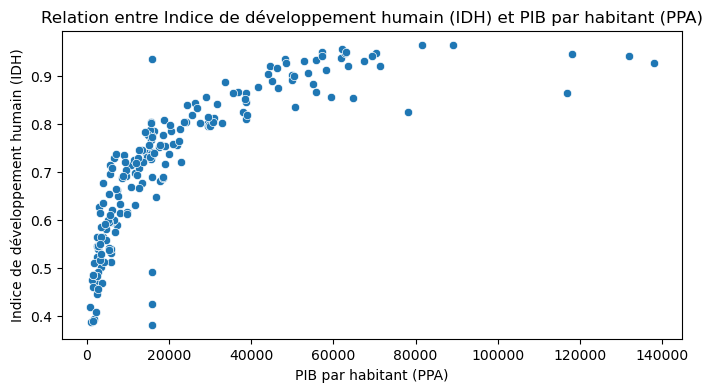

In [ ]:
# Relation entre IDH et PIB par habitant (PPA)
idh_col = "Indice de développement humain (IDH)"
plt.figure(figsize=(8, 4))
sns.scatterplot(x=data["PIB par habitant (PPA)"], y=data[idh_col])
plt.title(f"Relation entre {idh_col} et PIB par habitant (PPA)")
plt.xlabel("PIB par habitant (PPA)")
plt.ylabel(idh_col)
plt.show()

**Interprétations :**                                                                                                                             
Le graphique montre une relation positive et non linéaire entre l'Indice de Développement Humain (IDH) et le PIB par habitant (PPA). À mesure que le PIB par habitant augmente, l'IDH tend également à augmenter.                                                                     
Le PIB par habitant est un facteur clé du développement humain, mais son influence décroît à des niveaux très élevés, probablement parce que d'autres facteurs (éducation, santé, etc.) deviennent déterminants.                                       

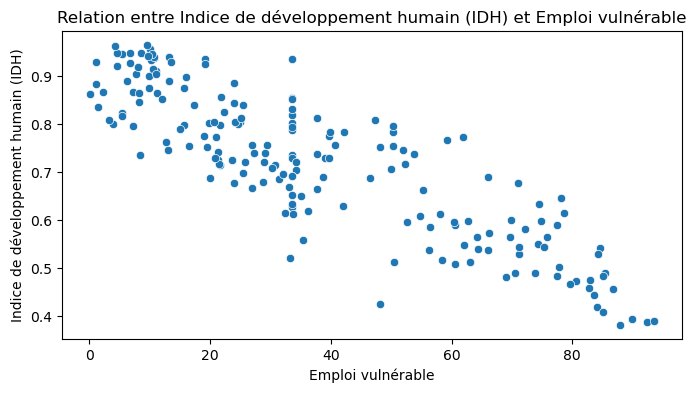

In [ ]:
# Relation entre IDH et Emploi vulnérable
plt.figure(figsize=(8, 4))
sns.scatterplot(x=data["Emploi vulnérable"], y=data[idh_col])
plt.title(f"Relation entre {idh_col} et Emploi vulnérable")
plt.xlabel("Emploi vulnérable")
plt.ylabel(idh_col)
plt.show()

**Interprétations :**                                                                                                                                  
Ce graphique montre une relation négative entre l'IDH et le pourcentage d'emplois vulnérables. Lorsque la proportion d'emplois vulnérables diminue, l'IDH augmente.                                                                                                                  
Les pays avec un faible taux d'emplois vulnérables (secteurs informels ou précaires) tendent à avoir un meilleur développement humain, probablement grâce à des emplois plus stables et formels qui favorisent la sécurité économique et sociale.

C:\Users\dell\AppData\Local\Temp\ipykernel_2812\2149144628.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=data["Niveau de développement"], palette="viridis")


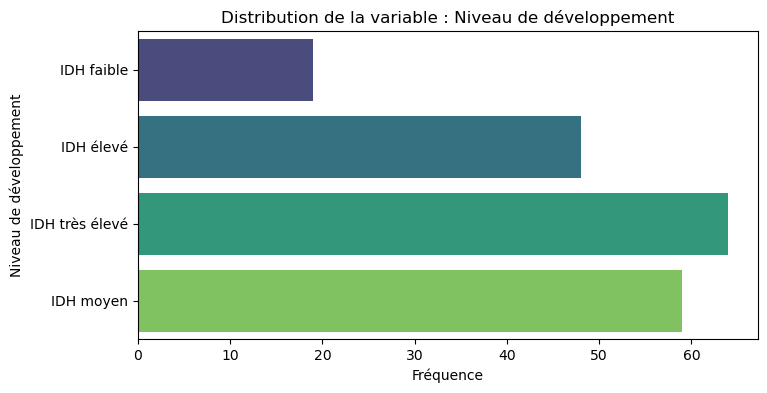

In [ ]:
# Distribution de la variable : Niveau de développement
plt.figure(figsize=(8, 4))
sns.countplot(y=data["Niveau de développement"], palette="viridis")
plt.title("Distribution de la variable : Niveau de développement")
plt.xlabel("Fréquence")
plt.ylabel("Niveau de développement")
plt.show()

**Interprétations :**                                                                                                                             
La catégorie IDH très élevé regroupe le plus grand nombre de pays, suivie par IDH moyen et IDH élevé.                                                 
La catégorie IDH faible contient le moins de pays.                                                                                    
Cela suggère que la majorité des pays se situent dans les niveaux moyens à très élevés de développement humain, avec relativement peu de pays dans la catégorie la plus faible.

C:\Users\dell\AppData\Local\Temp\ipykernel_2812\3676045824.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=data["Région géographique"], palette="viridis")


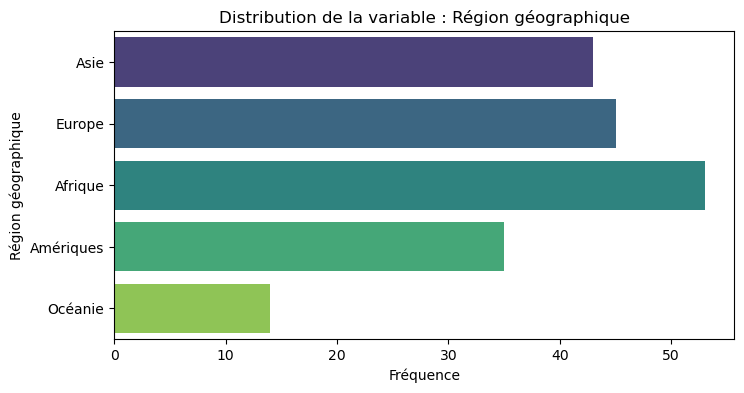

In [ ]:
# Distribution de la variable : Région géographique
plt.figure(figsize=(8, 4))
sns.countplot(y=data["Région géographique"], palette="viridis")
plt.title("Distribution de la variable : Région géographique")
plt.xlabel("Fréquence")
plt.ylabel("Région géographique")
plt.show()

**Interprétations :**                                                                                                                              
L'Afrique et l'Europe comptent le plus grand nombre de pays représentés dans l'échantillon.                                                           
L'Asie et les Amériques ont une représentation intermédiaire.                                                                               
L'Océanie est la région avec le plus faible nombre de pays dans l'échantillon.                                                                 
La répartition des données par région géographique semble cohérente avec le nombre total de pays par continent.

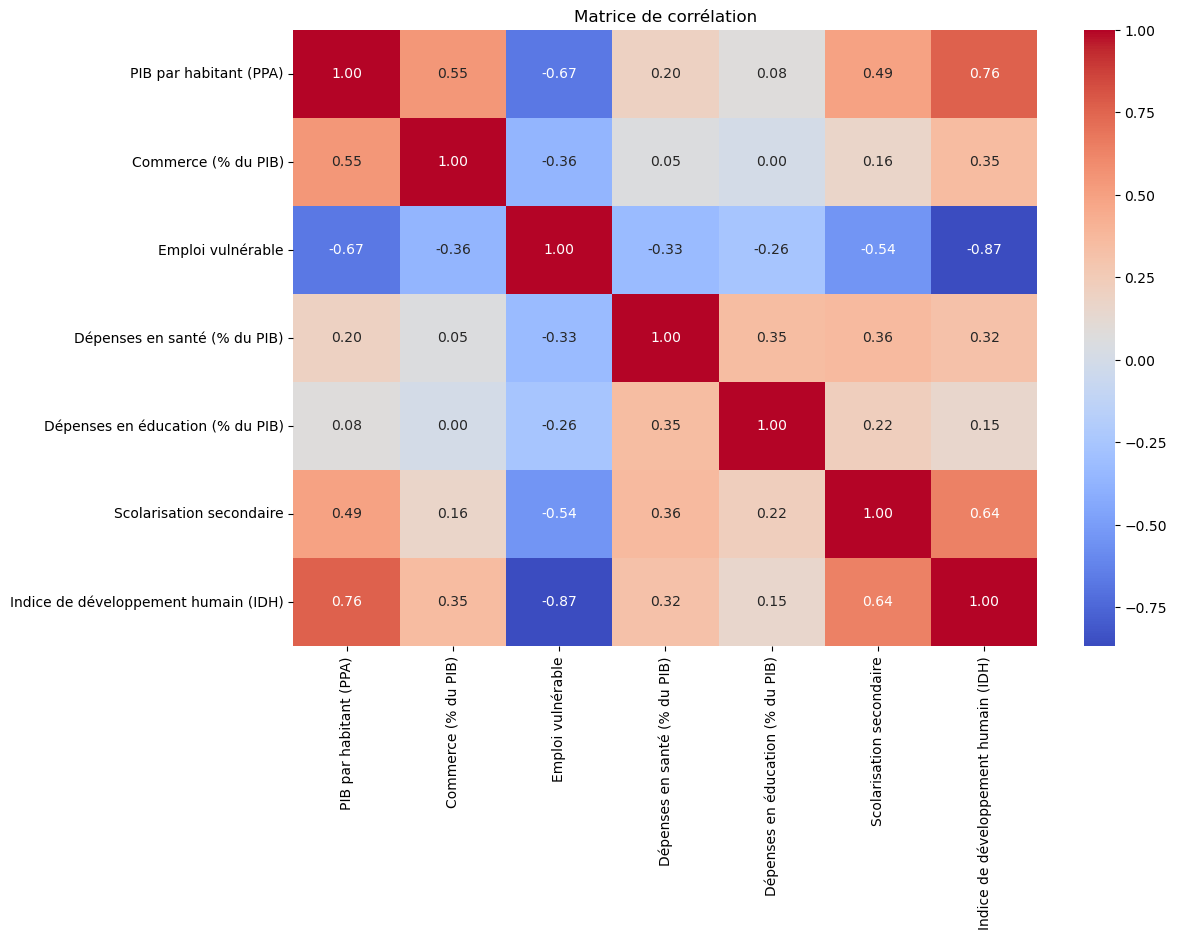

In [ ]:
# Matrice de corrélation
numeric_columns = data.select_dtypes(include=['float64', 'int64']).columns
plt.figure(figsize=(12, 8))
corr_matrix = data[numeric_columns].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Matrice de corrélation")
plt.show()

**intérprétations :**                                                                                                                                  
L'IDH est fortement influencé par le PIB par habitant et négativement par l'emploi vulnérable. Les dépenses en santé et la scolarisation secondaire ont également une contribution notable, bien que leurs corrélations soient plus faibles. Cela souligne l'importance des facteurs économiques et sociaux dans le développement humain.

### Analyse de données

In [ ]:
# Charger le dataset
file_path = 'final_data.csv'
data = pd.read_csv(file_path)

# Renommer les colonnes pour simplifier l'accès
data.rename(columns={
    'PIB par habitant (PPA)': 'PIB',
    'Commerce (% du PIB)': 'Commerce_PIB',
    'Emploi vulnérable': 'Emploi_Vulnerable',
    'Dépenses en santé (% du PIB)':'Depenses_Sante',
    'Dépenses en éducation (% du PIB)': 'Depenses_Education',
    'Scolarisation secondaire': 'Scolarisation',
    'Indice de développement humain (IDH)': 'IDH',
    'Niveau de développement': 'Niveau_Developpement',
    'Région géographique': 'Region'
}, inplace=True)

# Vérifier les nouvelles colonnes
print(data.columns)

Index(['Pays', 'PIB', 'Commerce_PIB', 'Emploi_Vulnerable', 'Depenses_Sante',
       'Depenses_Education', 'Scolarisation', 'IDH', 'Niveau_Developpement',
       'Region'],
      dtype='object')


#### Analyse de l'Impact de l'Emploi Vulnérable sur l'Indice de Développement Humain (IDH)
#### la Régression Linéaire

Étude 2 : IDH vs Emploi vulnérable


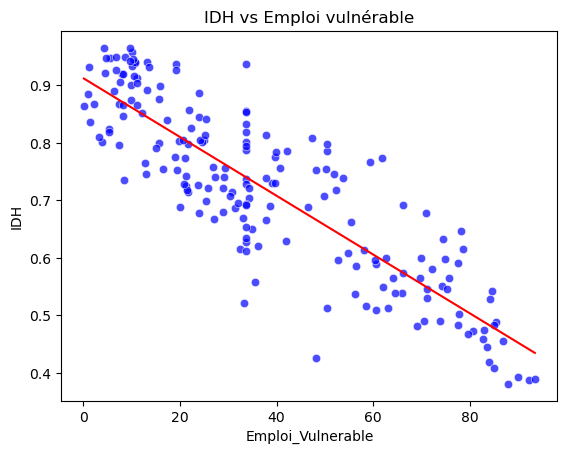

R-squared : 0.7505
Test de Durbin-Watson : 2.01
Test de White (Statistique): 11.04, p-value: 0.0040
Test de Shapiro-Wilk (Statistique): 0.99, p-value: 0.2503


In [ ]:
X = data[['Emploi_Vulnerable']]
y = data['IDH']

# Ajouter une constante
X = sm.add_constant(X)

# Ajuster le modèle
model_emploi = sm.OLS(y, X).fit()

# Résultats
print("Étude 2 : IDH vs Emploi vulnérable")

# Visualisation avec une droite rouge simple
sns.scatterplot(x='Emploi_Vulnerable', y='IDH', data=data, color='blue', alpha=0.7)
sns.lineplot(x=data['Emploi_Vulnerable'], y=model_emploi.predict(X), color='red')
plt.title("IDH vs Emploi vulnérable")
plt.show()

# Tests de régression
# Afficher R-squared
print(f"R-squared : {model_emploi.rsquared:.4f}")

# Test de Durbin-Watson
dw_test = sm.stats.stattools.durbin_watson(model_emploi.resid)
print(f"Test de Durbin-Watson : {dw_test:.2f}")

# Test de White pour l'hétéroscédasticité
white_test = het_white(model_emploi.resid, X)
print(f"Test de White (Statistique): {white_test[0]:.2f}, p-value: {white_test[1]:.4f}")

# Test de normalité de Shapiro-Wilk
shapiro_test = shapiro(model_emploi.resid)
print(f"Test de Shapiro-Wilk (Statistique): {shapiro_test.statistic:.2f}, p-value: {shapiro_test.pvalue:.4f}")


**interprétations :**
- La droite de régression montre une relation négative entre l'emploi vulnérable et l'IDH. Cela signifie que, généralement, lorsque le pourcentage d'emploi vulnérable augmente, l'Indice de Développement Humain (IDH) diminue.                                                                   
  La dispersion des points autour de la droite est relativement faible, indiquant une forte corrélation entre les deux variables.                   
- **R² = 0.7505** => Environ 75,05 % de la variance de l'IDH est expliquée par la variable "Emploi vulnérable", Ce R² est élevé, ce qui indique que l'emploi vulnérable est un facteur déterminant pour expliquer l'IDH.
- **Test de Durbin-Watson = 2.01** => Une valeur proche de 2 indique une absence d'autocorrélation significative. Ici, il n'y a pas de problème d'autocorrélation dans les résidus.
- **Test de White (Statistique = 11.04, p-value = 0.0040)** => Avec une p-value de 0.0040 (< 0.05), on rejette l'hypothèse nulle d'homoscédasticité. Cela indique qu'il y a un problème d'hétéroscédasticité dans le modèle, ce qui peut affecter la validité des estimations.
- **Test de Shapiro-Wilk (Statistique = 0.99, p-value = 0.2503)** => Avec une p-value de 0.2503 (> 0.05), on ne rejette pas l'hypothèse nulle de normalité. Les résidus suivent une distribution normale, ce qui valide l'utilisation des tests statistiques.                                       

#### L'Indice de Développement Humain (IDH) varie-t-il significativement selon les régions géographiques étudiées, indiquant des disparités de développement entre elles ?
#### ANOVA

Valeur de la statistique F : 65.0528627264025
Valeur p : 2.896418000899607e-34
Il existe une différence significative entre les moyennes de l'IDH des régions géographiques.


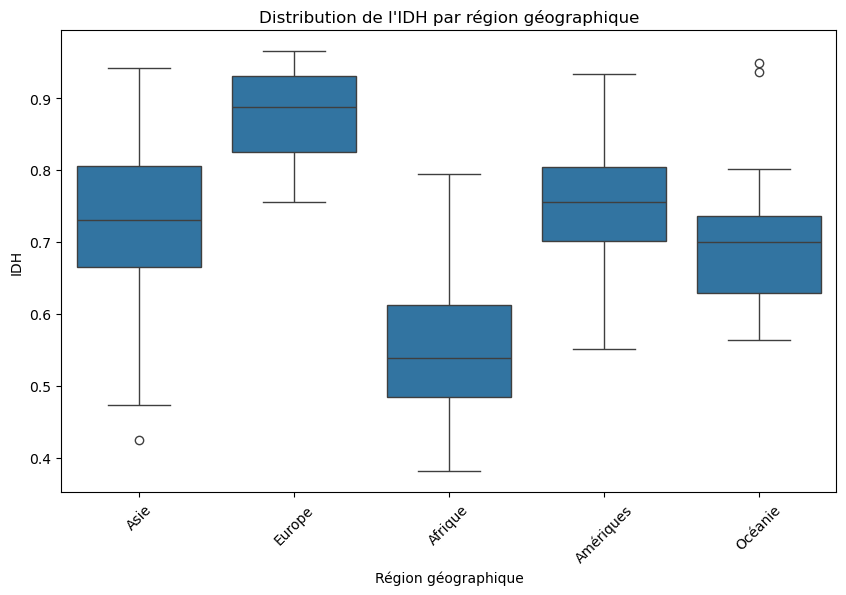

In [ ]:
# Effectuer le test ANOVA pour comparer l'IDH moyen entre les différentes régions
anova_result = stats.f_oneway(
    *(data[data['Region'] == region]['IDH'] for region in data['Region'].unique())
)

# Afficher le résultat du test ANOVA
print(f"Valeur de la statistique F : {anova_result.statistic}")
print(f"Valeur p : {anova_result.pvalue}")

# Conclusion du test
if anova_result.pvalue < 0.05:
    print("Il existe une différence significative entre les moyennes de l'IDH des régions géographiques.")
else:
    print("Il n'y a pas de différence significative entre les moyennes de l'IDH des régions géographiques.")

# Visualisation 1: Boxplot pour comparer la distribution de l'IDH entre les régions
plt.figure(figsize=(10, 6))
sns.boxplot(x='Region', y='IDH', data=data)
plt.title('Distribution de l\'IDH par région géographique')
plt.xlabel('Région géographique')
plt.ylabel('IDH')
plt.xticks(rotation=45)
plt.show()

**interprétations :**                                                                                                                                 
- L'Europe et les Amériques ont tendance à avoir des IDH plus élevés et moins variables.
- L'Afrique a les IDH les plus bas et une plus grande dispersion.
- L'Asie et l'Océanie présentent des situations intermédiaires.
- **Statistique F = 65.05** => Une valeur F élevée indique qu'il existe une grande différence entre les moyennes des groupes par rapport à la variabilité au sein de chaque groupe.
- **Valeur p = 2.9e-34** => Une valeur p très faible (bien inférieure à 0.05) montre que les différences observées entre les régions géographiques sont hautement significatives.
- Cela suggère que l'IDH varie de manière notable d'une région à l'autre, ce qui mérite d'être exploré davantage pour comprendre les facteurs sous-jacents à ces différences.     

#### Les niveaux de développement peuvent-ils être prédits à partir des indicateurs ?
#### La Régression Logistique

In [ ]:
# Encodage de la variable cible
label_encoder = LabelEncoder()
data['Niveau_Developpement'] = label_encoder.fit_transform(data['Niveau_Developpement'])

# Sélection des caractéristiques (variables explicatives)
features = [
    'PIB',
    'Commerce_PIB',
    'Emploi_Vulnerable',
    'Depenses_Sante',
    'Depenses_Education',
    'Scolarisation',
]
X = data[features]
y = data['Niveau_Developpement']  # Variable cible

# Division des données
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Normalisation des données
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Construction et entraînement du modèle
model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000)
model.fit(X_train, y_train)

# Prédiction sur l'ensemble de test
y_pred = model.predict(X_test)

# Évaluation du modèle
print("\nRapport de classification:\n", classification_report(y_test, y_pred))
print("Exactitude:", accuracy_score(y_test, y_pred))


Rapport de classification:
               precision    recall  f1-score   support

           0       1.00      0.17      0.29         6
           1       0.63      1.00      0.77        12
           2       1.00      0.86      0.92        21
           3       0.84      0.89      0.86        18

    accuracy                           0.82        57
   macro avg       0.87      0.73      0.71        57
weighted avg       0.87      0.82      0.81        57

Exactitude: 0.8245614035087719


**interprétations :**                                                                                                                              
**Exactitude (Accuracy) :** 82.46 %
Le modèle prédit correctement le niveau de développement (IDH) dans 82.46 % des cas, ce qui est une performance relativement bonne.                     
**Classe 0 (IDH faible) :** Très faible rappel (17 %) malgré une précision parfaite (1.00), Le modèle a du mal à identifier les pays à IDH faible, probablement en raison d'un déséquilibre des classes (peu d'exemples dans cette catégorie).                                                            
**Classe 1 (IDH moyen) :** Excellent rappel (1.00) mais précision modérée (0.71), ce qui suggère des confusions avec d'autres classes.                  
**Classe 2 (IDH élevé) :** Très bonnes performances globales avec une précision et un F1-score élevés (1.00 et 0.92).                                   
**Classe 3 (IDH très élevé) :** Solide performance avec un F1-score de 0.92, reflétant une excellente précision (0.86) et un rappel parfait (1.00).

Les facteurs économiques, sociaux et éducatifs identifiés comme influents sur l’IDH semblent pertinents pour la classification, mais un déséquilibre des données limite la performance pour certaines catégories.

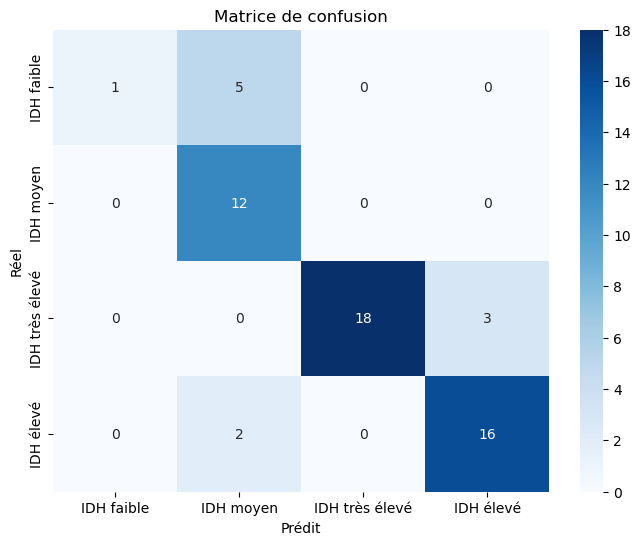

In [ ]:
# Visualisation de la matrice de confusion
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel('Prédit')
plt.ylabel('Réel')
plt.title('Matrice de confusion')
plt.show()

**interprétations :**                                                                                                                              
- **IDH faible (Classe 0) :**
1 correctement prédit, 5 mal classés comme IDH moyen.
Le modèle a du mal à identifier les pays à IDH faible, probablement en raison d'un déséquilibre des classes ou de caractéristiques insuffisamment discriminantes.

- **IDH moyen (Classe 1) :**
12 correctement prédits, aucune erreur.
Le modèle performe bien pour cette catégorie, identifiant tous les pays à IDH moyen sans erreur.

- **IDH élevé (Classe 2) :**
18 correctement prédits, 3 mal classés comme IDH très élevé.
Bonne performance, mais une légère confusion avec l'IDH très élevé.

- **IDH très élevé (Classe 3) :**
16 correctement prédits, 2 mal classés comme IDH élevé.
Le modèle identifie bien cette catégorie, avec une légère confusion avec l'IDH élevé.

- Les résultats montrent que les facteurs économiques, sociaux et éducatifs influencent significativement l'IDH, avec une bonne performance du modèle pour les IDH moyen, élevé et très élevé. Cependant, la faible précision pour les IDH faibles suggère l'importance de facteurs supplémentaires ou des limites dans les données pour ces pays.

#### Quels facteurs économiques, sociaux et éducatifs peuvent être synthétisés pour mieux comprendre leur impact sur l’IDH ?
#### ACP

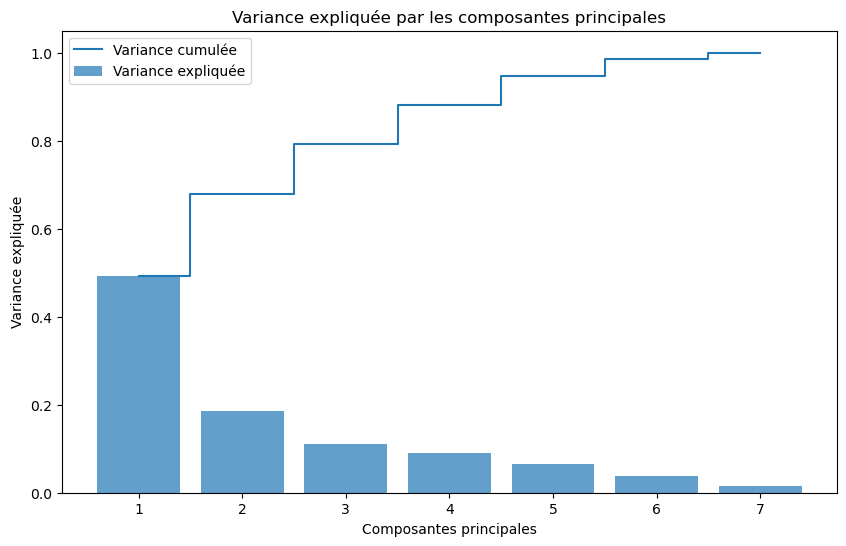

In [ ]:
# Sélection des colonnes numériques pour l'ACP
numerical_columns = [
    'PIB',
    'Commerce_PIB',
    'Emploi_Vulnerable',
    'Depenses_Sante',
    'Depenses_Education',
    'Scolarisation',
    'IDH'
]

# Standardisation des données
scaler = StandardScaler()
X_scaled = scaler.fit_transform(data[numerical_columns])

# Application de l'ACP
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# Variance expliquée par chaque composante
explained_variance = pca.explained_variance_ratio_

# Visualisation de la variance expliquée
plt.figure(figsize=(10, 6))
plt.bar(range(1, len(explained_variance) + 1), explained_variance, alpha=0.7, align='center', label='Variance expliquée')
plt.step(range(1, len(explained_variance) + 1), explained_variance.cumsum(), where='mid', label='Variance cumulée')
plt.xlabel('Composantes principales')
plt.ylabel('Variance expliquée')
plt.title('Variance expliquée par les composantes principales')
plt.legend()
plt.show()

**intérprétations :**                                                                                                                                 
Le graphique montre que les 2 premières composantes principales expliquent environ 70% de la variance totale. Cela indique que ces composantes capturent une grande partie de l'information contenue dans les données initiales.

In [ ]:
# Affichage des composantes principales
pca_components = pd.DataFrame(pca.components_, columns=numerical_columns)
pca_components.head()

,PIB,Commerce_PIB,Emploi_Vulnerable,Depenses_Sante,Depenses_Education,Scolarisation,IDH
0,0.451145,0.273873,-0.477997,0.253452,0.167025,0.395511,0.494385
1,-0.290182,-0.458060,0.021405,0.537621,0.615854,0.173862,-0.083523
2,0.053303,0.680547,0.084815,0.082279,0.540938,-0.413323,-0.237911
3,-0.023746,0.238727,0.194045,0.782170,-0.527628,-0.039186,-0.114347
4,-0.065523,0.306333,0.436458,-0.158738,0.063972,0.785122,-0.256251


- **Composante principale 1 (CP1) :**                                                                                                             
Variables principales : PIB (+), Scolarisation (+), IDH (+), et Emploi vulnérable (-).                                                               
**Interprétation :** Cette composante semble capturer le niveau de développement socio-économique, où un PIB élevé, une meilleure scolarisation, et un IDH élevé sont associés à un emploi vulnérable plus faible.
- **Composante principale 2 (CP2) :**                                                                                                                  
Variables principales : Commerce (+), Dépenses en santé (+), et Dépenses en éducation (+).                                                         
**Interprétation :** Cette composante est liée aux investissements dans le commerce, la santé et l'éducation, sans lien direct avec le niveau d'IDH.  

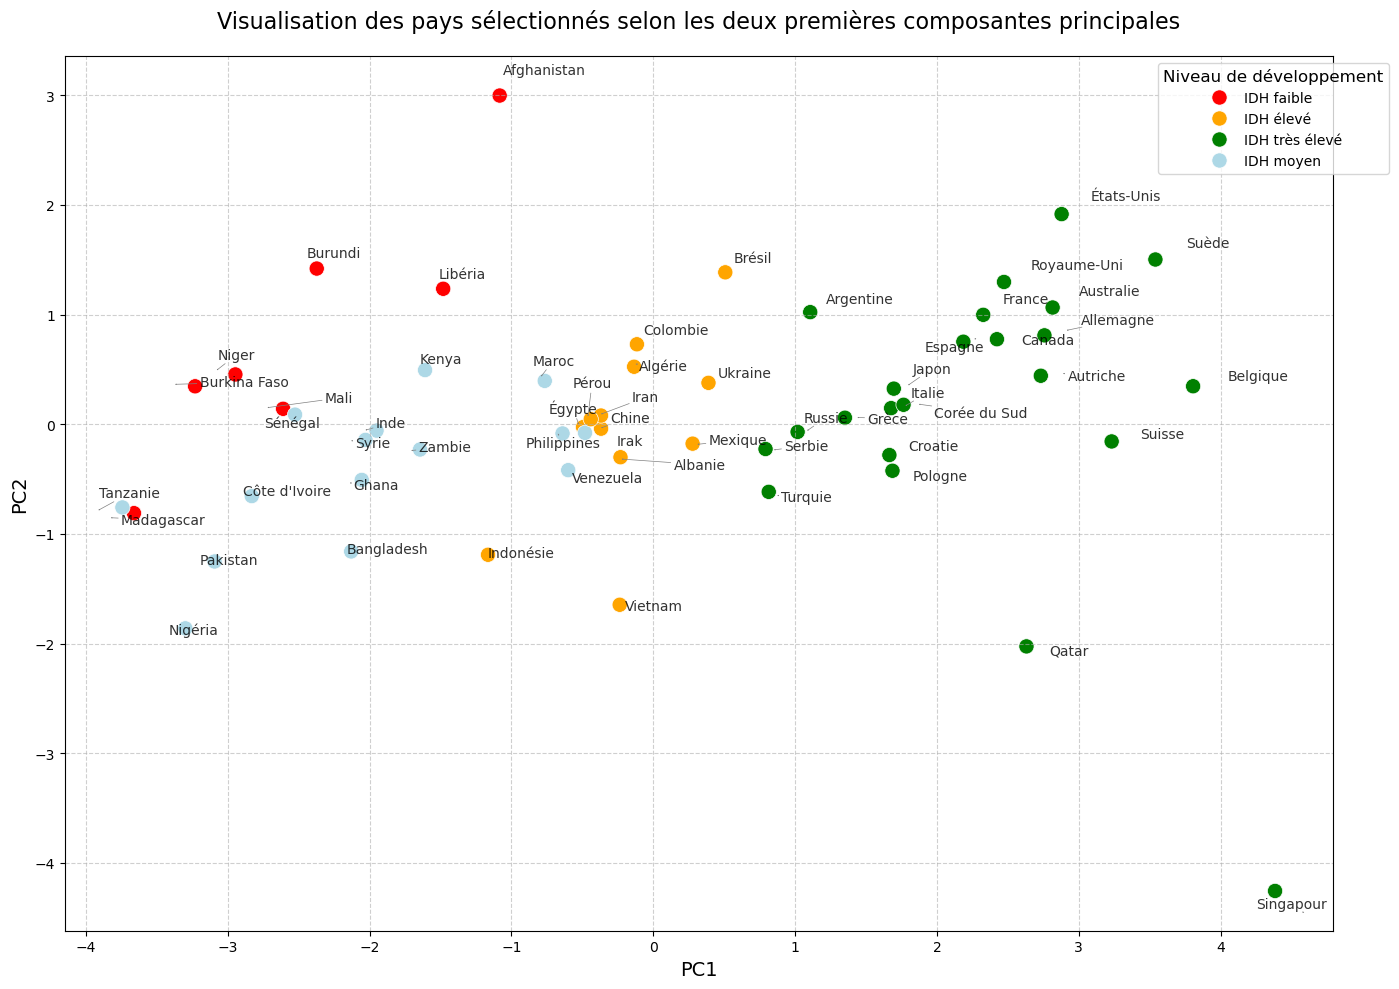

In [ ]:
# 1. Sélectionner les colonnes numériques
numerical_data = data.select_dtypes(include='float64')

# 2. Normaliser les données
scaler = StandardScaler()
normalized_data = scaler.fit_transform(numerical_data)

# 3. Appliquer l'ACP
pca = PCA()
pca_data = pca.fit_transform(normalized_data)

# Variance expliquée par chaque composante
explained_variance = pca.explained_variance_ratio_

# Création d'un DataFrame des deux premières composantes
pca_df = pd.DataFrame(data=pca_data[:, :2], columns=['PC1', 'PC2'])
pca_df['Pays'] = data['Pays']
pca_df['Niveau_Developpement'] = data['Niveau_Developpement']


# Liste des pays sélectionnés
countries_selected = [
    'Afghanistan', 'Albanie', 'Algérie', 'Allemagne', 'Argentine', 'Australie', 'Autriche', 'Bangladesh',
    'Belgique', 'Brésil', 'Canada', 'Chine', 'Colombie', 'Corée du Sud', 'Côte d\'Ivoire', 'Croatie', 'Égypte', 'Espagne',
    'États-Unis', 'France', 'Ghana', 'Grèce', 'Inde', 'Indonésie', 'Iran', 'Irak', 'Qatar', 'Italie', 'Japon',
    'Kenya', 'Maroc', 'Mexique', 'Nigéria', 'Pakistan', 'Pérou', 'Philippines', 'Pologne', 'Qatar', 'Royaume-Uni', 'Russie',
    'Sénégal', 'Serbie', 'Singapour', 'Suède', 'Suisse', 'Syrie', 'Tanzanie', 'Turquie', 'Ukraine', 'Venezuela',
    'Vietnam', 'Zambie', 'Mali', 'Burkina Faso', 'Niger', 'Madagascar', 'Libéria', 'Burundi'
]


# Définir une palette de couleurs personnalisée
custom_palette = {
    'IDH faible': 'red',
    'IDH très élevé': 'green',
    'IDH moyen': 'lightblue',
    'IDH élevé': 'orange'
}

# Filtrer les données pour ne garder que les pays sélectionnés
filtered_data = pca_df[pca_df['Pays'].isin(countries_selected)]

# Visualisation des pays sélectionnés selon les deux premières composantes principales
plt.figure(figsize=(14, 10))
scatter = sns.scatterplot(x='PC1', y='PC2', data=filtered_data,
                          hue=data.loc[filtered_data.index, 'Niveau_Developpement'],
                          palette=custom_palette, s=120, edgecolor='w', linewidth=0.5)

# Ajouter des labels pour chaque pays
texts = []
for i, country in enumerate(filtered_data['Pays']):
    texts.append(plt.text(filtered_data.iloc[i]['PC1'] * 1.05, filtered_data.iloc[i]['PC2'] * 1.05, country,
                          fontsize=10, color='black', alpha=0.8))

# Ajuster les positions des labels pour éviter les chevauchements
adjust_text(texts, arrowprops=dict(arrowstyle='->', color='grey', lw=0.5))

# Ajouter des configurations
plt.title('Visualisation des pays sélectionnés selon les deux premières composantes principales', fontsize=16, pad=20)
plt.xlabel('PC1', fontsize=14)
plt.ylabel('PC2', fontsize=14)
plt.legend(title='Niveau de développement', bbox_to_anchor=(1.05, 1), title_fontsize=12, fontsize=10)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

**intérprétations :**                                                                                                                                 
La projection des pays sur les deux premières composantes principales montre que les pays sont répartis en fonction de leur niveau de développement humain, avec une séparation claire entre les pays à IDH très élevé/élevé et ceux à IDH faible/moyen. Cela suggère que les facteurs économiques, sociaux et éducatifs analysés sont des déterminants importants de l'IDH et peuvent guider des décisions stratégiques pour améliorer le développement humain.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


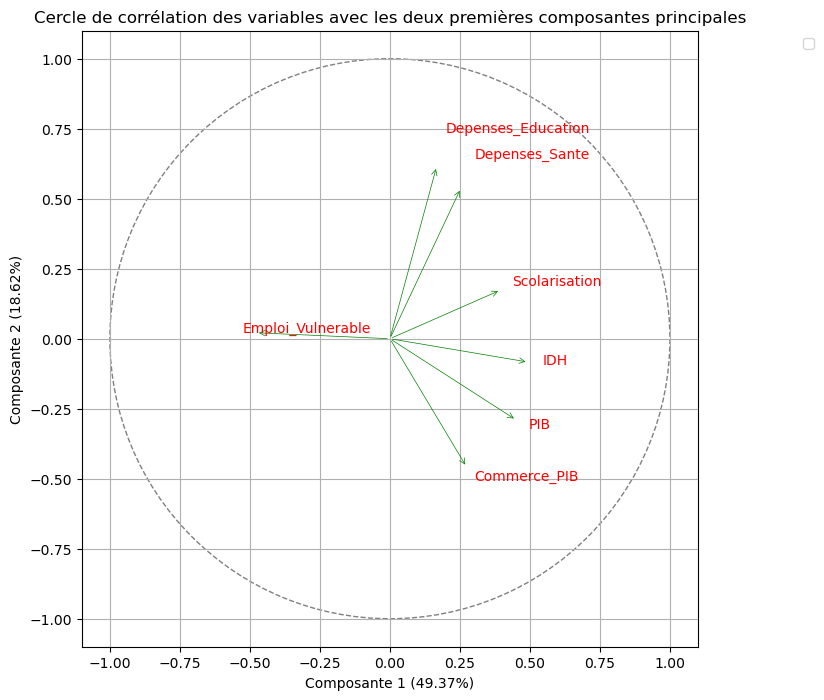

In [ ]:
# Calculer les corrélations entre les variables restantes et les composantes principales
correlation_matrix = pd.DataFrame(pca.components_[:2], columns=numerical_data.columns, index=['PC1', 'PC2'])

# Visualisation du cercle de corrélation
plt.figure(figsize=(8, 8))
ax = plt.gca()

# Tracer les vecteurs avec des flèches vertes fines
for i, var in enumerate(numerical_data.columns):
    ax.annotate('', xy=(correlation_matrix.loc['PC1', var], correlation_matrix.loc['PC2', var]),
                xytext=(0, 0),
                arrowprops=dict(facecolor='green', edgecolor='green', arrowstyle='->', linewidth=0.5))

# Ajouter des labels pour chaque vecteur en rouge, avec un décalage pour éviter les chevauchements près du cercle
for i, var in enumerate(numerical_data.columns):
    # Décalage des labels en fonction de la position des vecteurs
    if abs(correlation_matrix.loc['PC1', var]) > 0.5 or abs(correlation_matrix.loc['PC2', var]) > 0.5:
        ax.text(correlation_matrix.loc['PC1', var] * 1.2, correlation_matrix.loc['PC2', var] * 1.2, var, color='red')
    else:
        ax.text(correlation_matrix.loc['PC1', var] * 1.1, correlation_matrix.loc['PC2', var] * 1.1, var, color='red')

# Ajouter un cercle unitaire pour mieux visualiser les corrélations
circle = plt.Circle((0, 0), 1, color='gray', fill=False, linestyle='--')
ax.add_artist(circle)

# Configurations de la visualisation
ax.set_xlim(-1.1, 1.1)
ax.set_ylim(-1.1, 1.1)
plt.xlabel(f'Composante 1 ({explained_variance[0] * 100:.2f}%)')
plt.ylabel(f'Composante 2 ({explained_variance[1] * 100:.2f}%)')
ax.set_title('Cercle de corrélation des variables avec les deux premières composantes principales')
ax.set_aspect('equal')
ax.legend(loc='upper right', bbox_to_anchor=(1.2, 1))
plt.grid(True)
plt.show()

**interprétations :**                                                                                                                                 
- **Facteurs économiques :**                                                                                                                           
Le PIB par habitant est fortement lié à l’IDH, confirmant que la richesse économique est essentielle au développement humain. Le commerce joue un rôle secondaire.                                                                                                                                       
- **Facteurs sociaux :**
Un emploi vulnérable élevé est opposé à l’IDH, indiquant que réduire la précarité économique est crucial pour améliorer le développement humain.       
- **Facteurs éducatifs :**
La scolarisation secondaire est un levier majeur pour l’IDH. Les dépenses en éducation contribuent modérément, leur impact dépendant de leur        efficacité.                                                                                                                                            
- **Facteurs liés à la santé :**                                                                                                                       
Les dépenses en santé soutiennent l’IDH mais nécessitent des efforts complémentaires pour maximiser leur impact.                                       

- L’IDH est principalement influencé par le PIB, la réduction de l’emploi vulnérable, et la scolarisation, tandis que les investissements dans la santé et l’éducation jouent un rôle de soutien.

#**Conclusion :**

À travers ce projet d’analyse de données, nous avons exploré des relations entre les indicateurs économiques, sociaux, et éducatifs, en nous appuyant sur trois jeux de données complémentaires. Les résultats montrent que :

* Éducation et emploi (Dataset 1) : Les niveaux d’éducation et les domaines d’études jouent un rôle déterminant dans les taux d’emploi et de chômage. Les individus ayant un niveau d’éducation plus élevé et des spécialités en forte demande sur le marché du travail présentent des taux d’emploi plus élevés.

* Politiques publiques et performances socio-économiques (Dataset 2) : Les pays ayant des politiques fiscales équilibrées et des investissements conséquents dans l’éducation et la santé obtiennent de meilleurs résultats en termes de taux d’emploi, de réduction de la pauvreté, et d’accès aux services essentiels.

* Disparités en développement humain (Dataset 3) : Les pays avec un IDH élevé bénéficient d’indicateurs économiques solides (PIB par habitant élevé, faible emploi vulnérable) et d’investissements soutenus dans l’éducation et la santé. En revanche, les pays à faible IDH restent marqués par des inégalités socio-économiques importantes.

**Recommandations**:

Pour réduire les inégalités globales, il est essentiel :

D’investir davantage dans l’éducation, en alignant les programmes avec les besoins du marché du travail.
De promouvoir des politiques fiscales et sociales inclusives pour soutenir les populations vulnérables.
D’encourager la coopération internationale pour aider les pays en développement à renforcer leurs infrastructures éducatives et économiques.
Ce projet démontre l’importance d’une analyse multidimensionnelle pour comprendre les défis globaux et propose des pistes d’amélioration basées sur les données disponibles.